In [231]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [232]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [233]:
DAY22 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')

start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.314,1.592,-0.017,0.700,0.009,0.011
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.314,1.592,-0.017,0.700,0.009,0.011
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.314,1.592,-0.017,0.700,0.009,0.011
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.314,1.592,-0.017,0.700,0.009,0.011
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.314,1.592,-0.017,0.700,0.009,0.011
...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.437,0.139,-0.021,0.195,0.007,0.029
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.437,0.139,-0.021,0.195,0.007,0.029
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.437,0.139,-0.021,0.195,0.007,0.029
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.437,0.139,-0.021,0.195,0.007,0.029


In [234]:
nbins = 10
bins = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins)
DAY22_subset_mean = DAY22_subset.groupby('Bins').mean()
DAY22_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(105.985, 477.83]",2022-06-02 12:59:24.379310336,2022-06-02 12:59:25.379310336,32.920522,-69.390343,268.173621,0.482448,1.559500,-0.038466,0.662069,0.004000,0.027810
"(477.83, 849.676]",2022-06-02 13:00:16.000000000,2022-06-02 13:00:17.000000000,32.954623,-69.409475,663.917000,0.083556,1.411889,0.004000,0.549111,0.029000,0.046444
"(849.676, 1221.522]",2022-06-02 13:01:00.999999744,2022-06-02 13:01:01.999999744,32.923986,-69.435929,1036.466556,0.357444,1.045000,-0.004333,0.252222,0.009111,0.032333
"(1221.522, 1593.367]",2022-06-02 13:01:47.500000000,2022-06-02 13:01:48.500000000,32.906256,-69.389040,1411.095417,0.473250,0.660312,0.018542,0.300354,-0.007167,-0.026958
"(1593.367, 1965.212]",2022-06-02 13:02:33.000000000,2022-06-02 13:02:34.000000000,32.946729,-69.372567,1779.189767,0.338442,0.573814,0.067093,0.059791,-0.025209,0.008116
"(1965.212, 2337.058]",2022-06-02 13:03:21.000000000,2022-06-02 13:03:22.000000000,32.952007,-69.422735,2141.850000,0.527981,0.376472,0.174208,0.161811,-0.022377,0.077811
"(2337.058, 2708.904]",2022-06-02 13:04:12.500000000,2022-06-02 13:04:13.499999744,32.906590,-69.413941,2515.723600,0.828240,0.465160,0.117060,0.594220,0.000660,0.110100
"(2708.904, 3080.749]",2022-06-02 13:05:05.000000000,2022-06-02 13:05:06.000000000,32.925327,-69.357363,2905.013636,0.950400,0.405273,0.032564,0.404491,0.035582,0.136673
"(3080.749, 3452.594]",2022-06-02 13:06:00.000000000,2022-06-02 13:06:01.000000000,32.966644,-69.388586,3268.069273,0.192545,0.252364,0.018818,0.440818,0.001636,-0.018364


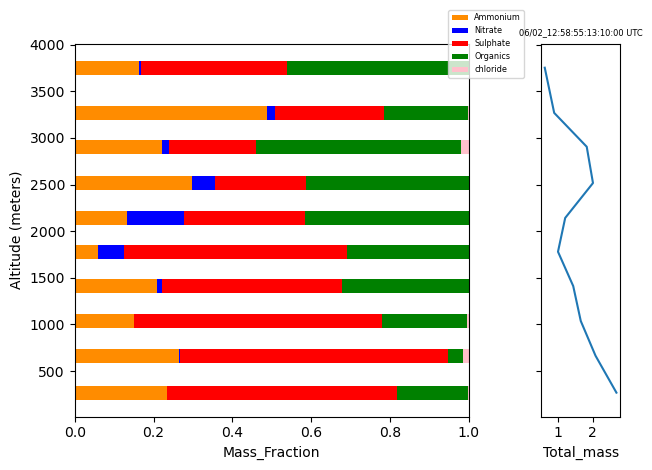

In [235]:
normal = (DAY22_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY22_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY22_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY22_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY22_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY22_subset_mean['AMS'] = normal
DAY22_subset_mean = DAY22_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY22_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal
y2 = DAY22_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal
y3 = DAY22_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal
y4 = DAY22_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal
y5 = DAY22_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal
y6 = DAY22_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal


fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY22_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal, DAY22_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.title('06/02_12:58:55:13:10:00 UTC',  fontsize=6)
plt.tight_layout()

In [326]:
DAY2 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:11:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049
...,...,...,...,...,...,...,...,...,...,...,...
10301,2022-06-02 14:10:55,2022-06-02 14:10:56,32.264343,-65.038703,3176.07,0.025,0.127,0.054,0.261,-0.012,-0.051
10302,2022-06-02 14:10:56,2022-06-02 14:10:57,32.263327,-65.039317,3180.14,0.025,0.127,0.054,0.261,-0.012,-0.051
10303,2022-06-02 14:10:57,2022-06-02 14:10:58,32.262289,-65.039886,3184.23,0.025,0.127,0.054,0.261,-0.012,-0.051
10304,2022-06-02 14:10:58,2022-06-02 14:10:59,32.261232,-65.040413,3188.41,0.025,0.127,0.054,0.261,-0.012,-0.051


In [327]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-02 13:57:54.582257664,2022-06-02 13:57:55.582257920,32.257599,-65.148399,538.172355,0.315886,1.429386,0.020967,0.432283,0.006848,0.012534
min,2022-06-02 13:54:38.938053120,2022-06-02 13:54:39.938052864,32.208644,-65.314203,122.186728,-0.034000,1.117500,-0.014257,0.160000,-0.030917,-0.045159
25%,2022-06-02 13:57:46.196428800,2022-06-02 13:57:47.196428544,32.245388,-65.208162,329.962969,0.230813,1.341165,0.001075,0.357130,-0.009341,-0.013110
50%,2022-06-02 13:58:06.365384704,2022-06-02 13:58:07.365384704,32.262099,-65.150358,534.214875,0.389402,1.455327,0.018608,0.470905,0.006103,0.012762
75%,2022-06-02 13:58:25.548077056,2022-06-02 13:58:26.548077056,32.274028,-65.064415,745.533750,0.429442,1.515912,0.042384,0.531900,0.023036,0.036042
max,2022-06-02 13:59:20,2022-06-02 13:59:21,32.293294,-65.031089,955.237500,0.500450,1.641000,0.063538,0.634000,0.070444,0.062769
std,NaN,NaN,0.023063,0.080815,253.373513,0.166097,0.142147,0.025365,0.127741,0.023279,0.030771


In [328]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,64,64,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,2022-06-02 14:04:08.354757888,2022-06-02 14:04:09.354758144,32.269705,-65.097703,1989.237665,0.451857,0.590304,0.015855,0.330821,0.012730,0.029010
min,2022-06-02 13:49:49.210526464,2022-06-02 13:49:50.210526464,32.218667,-65.794598,1016.933750,-0.053800,0.187000,-0.099000,-0.174000,-0.045000,-0.060909
25%,2022-06-02 14:00:09.400000,2022-06-02 14:00:10.400000,32.259215,-65.176425,1503.675179,0.246012,0.370583,-0.019571,0.252875,-0.002667,-0.001700
50%,2022-06-02 14:06:26,2022-06-02 14:06:27,32.270979,-65.042543,1987.669125,0.475000,0.584000,0.002000,0.348000,0.020500,0.021600
75%,2022-06-02 14:08:27,2022-06-02 14:08:28,32.281377,-64.984784,2473.398214,0.654000,0.808400,0.048500,0.418583,0.027000,0.078000
max,2022-06-02 14:10:13.500000,2022-06-02 14:10:14.500000,32.374333,-64.956005,2963.316667,0.926000,1.119636,0.119000,0.507000,0.036417,0.109000
std,NaN,NaN,0.028406,0.150826,574.436478,0.257642,0.269500,0.054303,0.130932,0.020378,0.050982


In [329]:
nbins = 10
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_mean = DAY2_subset.groupby('Bins').mean()
DAY2_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(106.28, 414.935]",2022-06-02 13:58:08.431279616,2022-06-02 13:58:09.431279616,32.222284,-65.052262,201.713531,0.347882,1.460886,0.019768,0.532744,0.010768,-0.001948
"(414.935, 723.59]",2022-06-02 13:56:14.760124672,2022-06-02 13:56:15.760124672,32.278362,-65.237338,496.177975,0.167595,1.548607,0.025006,0.321972,0.005271,-0.008171
"(723.59, 1032.245]",2022-06-02 13:58:24.139785216,2022-06-02 13:58:25.139784960,32.261564,-65.187799,860.475645,0.352226,1.231828,0.030613,0.475505,0.017376,-0.001516
"(1032.245, 1340.9]",2022-06-02 13:59:52.220000000,2022-06-02 13:59:53.220000000,32.282997,-65.127592,1188.504500,0.084800,0.970580,0.020220,0.411260,0.007120,-0.045680
"(1340.9, 1649.555]",2022-06-02 14:00:24.388888832,2022-06-02 14:00:25.388888832,32.289127,-65.192270,1506.377963,0.250731,0.808657,-0.000222,0.399454,0.031787,0.010472
"(1649.555, 1958.21]",2022-06-02 13:54:36.863636480,2022-06-02 13:54:37.863636480,32.325073,-65.525992,1861.040795,0.377530,0.488000,0.027117,0.268504,0.004587,0.010148
"(1958.21, 2266.865]",2022-06-02 14:06:53.500000000,2022-06-02 14:06:54.500000000,32.275347,-64.994419,2105.129861,0.679028,0.594250,-0.002333,0.402306,-0.011389,0.068194
"(2266.865, 2575.52]",2022-06-02 14:08:09.500000000,2022-06-02 14:08:10.500000000,32.239450,-65.028426,2422.122750,0.711625,0.316125,0.039500,0.300500,0.007625,0.097625
"(2575.52, 2884.175]",2022-06-02 14:09:24.500000000,2022-06-02 14:09:25.500000000,32.244135,-64.965350,2731.323286,0.643214,0.301029,0.025700,0.234829,0.021886,0.034857


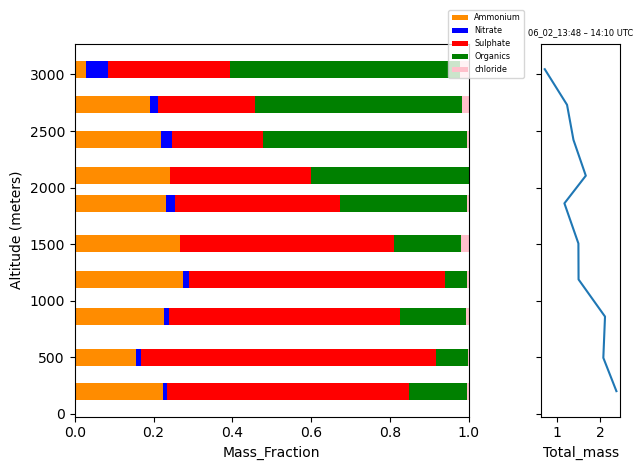

In [330]:
normal = (DAY2_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY2_subset_mean['AMS'] = normal
DAY2_subset_mean = DAY2_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY2_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal
y2 = DAY2_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal
y3 = DAY2_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal
y4 = DAY2_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal
y5 = DAY2_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal
y6 = DAY2_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal


fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal, DAY2_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.title('06_02_13:48 – 14:10 UTC', fontsize=6)
plt.tight_layout()

In [241]:
DAY2b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L2_20230614T111634.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033
...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066


In [242]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,23,23,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2022-06-02 18:38:51.723478272,2022-06-02 18:38:52.723478528,32.264959,-65.002657,542.968740,0.241582,1.147534,-0.017463,0.361457,0.006726,-0.006375
min,2022-06-02 18:36:19.440000,2022-06-02 18:36:20.440000,32.237006,-65.038727,150.110167,-0.179000,0.874000,-0.113000,0.057000,-0.038000,-0.073000
25%,2022-06-02 18:37:45.500000,2022-06-02 18:37:46.500000,32.245356,-65.024746,347.205500,0.097200,1.009000,-0.060000,0.352000,-0.023450,-0.051000
50%,2022-06-02 18:38:58,2022-06-02 18:38:59,32.259206,-65.007059,546.110000,0.284000,1.092615,-0.013000,0.372000,0.014000,0.003000
75%,2022-06-02 18:40:00.750000128,2022-06-02 18:40:01.750000128,32.284653,-64.979873,738.915675,0.393000,1.222000,0.020500,0.447250,0.033651,0.021231
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.302282,-64.962424,939.254583,0.618200,1.527333,0.084000,0.486000,0.051333,0.068000
std,NaN,NaN,0.021253,0.025022,242.938577,0.216043,0.188750,0.060259,0.123650,0.030089,0.044057


In [243]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,69,69,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2022-06-02 18:47:10.028985344,2022-06-02 18:47:11.028985600,32.292125,-64.972806,2222.171291,0.417963,0.360546,-0.005058,0.140586,0.009712,0.024835
min,2022-06-02 18:41:23,2022-06-02 18:41:24,32.245140,-65.034343,1010.109286,0.099000,0.076000,-0.080000,-0.205000,-0.030000,-0.043000
25%,2022-06-02 18:44:20,2022-06-02 18:44:21,32.265371,-65.005661,1613.940000,0.191000,0.180000,-0.042000,-0.027000,-0.006000,-0.020000
50%,2022-06-02 18:47:13.500000,2022-06-02 18:47:14.500000,32.291366,-64.976928,2220.819167,0.361182,0.236000,-0.004000,0.147000,0.012000,0.004385
75%,2022-06-02 18:50:23.500000,2022-06-02 18:50:24.500000,32.320182,-64.941826,2828.515000,0.521000,0.553000,0.025000,0.312000,0.026000,0.041000
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.340694,-64.908365,3434.677778,1.357000,0.867714,0.107000,0.552000,0.045000,0.182000
std,NaN,NaN,0.030815,0.037796,716.746439,0.288375,0.224696,0.044561,0.202743,0.021004,0.057277


In [244]:
nbins = 10
bins2b = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins2b)
DAY2b_subset_mean= DAY2b_subset.groupby('Bins').mean()
DAY2b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.5, 489.666]",2022-06-02 18:37:16.217105408,2022-06-02 18:37:17.217105152,32.266738,-65.013899,277.766842,0.345803,1.332441,0.030395,0.283993,0.024914,0.018164
"(489.666, 846.832]",2022-06-02 18:39:34.500000000,2022-06-02 18:39:35.500000000,32.275278,-65.003346,658.362460,0.248411,1.078548,-0.053492,0.385919,0.000387,-0.027355
"(846.832, 1203.998]",2022-06-02 18:41:27.500000000,2022-06-02 18:41:28.500000000,32.275312,-64.961205,1027.121569,0.166608,0.828098,0.002618,0.283676,-0.006382,-0.009529
"(1203.998, 1561.164]",2022-06-02 18:43:13.500000000,2022-06-02 18:43:14.500000000,32.268556,-64.987369,1380.780182,0.416545,0.598000,-0.026818,0.296909,0.008318,0.055455
"(1561.164, 1918.33]",2022-06-02 18:44:56.000000000,2022-06-02 18:44:57.000000000,32.295981,-64.924398,1745.476105,0.515653,0.463105,0.004284,0.244895,0.022253,0.034905
"(1918.33, 2275.496]",2022-06-02 18:46:35.499999744,2022-06-02 18:46:36.500000256,32.325801,-65.004061,2098.379231,0.967846,0.421394,0.051875,-0.055500,-0.010385,0.133519
"(2275.496, 2632.662]",2022-06-02 18:48:22.500000000,2022-06-02 18:48:23.499999744,32.256820,-64.976159,2462.503000,0.325973,0.136955,-0.018691,-0.090882,-0.005427,-0.000264
"(2632.662, 2989.828]",2022-06-02 18:50:07.000000000,2022-06-02 18:50:07.999999744,32.315637,-64.932314,2788.535960,0.392697,0.141121,-0.017818,0.167788,0.020909,-0.013152
"(2989.828, 3346.994]",2022-06-02 18:51:26.500000000,2022-06-02 18:51:27.500000000,32.299653,-65.001226,3160.220167,0.169967,0.186367,-0.043367,0.240867,0.025600,-0.026533


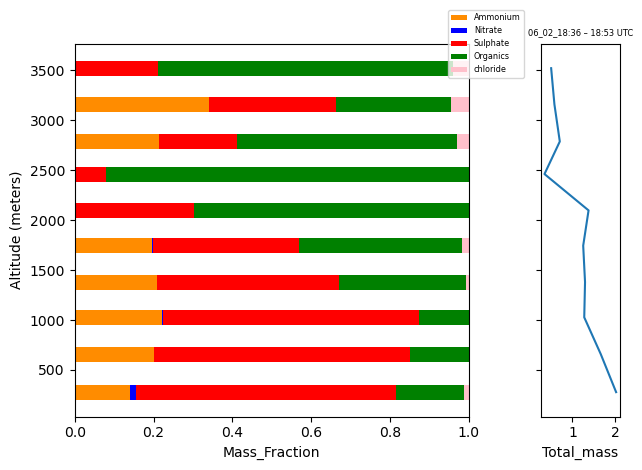

In [245]:
normal = (DAY2b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY2b_subset_mean['AMS'] = normal
DAY2b_subset_mean = DAY2b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY2b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal
y2 = DAY2b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal
y3 = DAY2b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal
y4 = DAY2b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal
y5 = DAY2b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal
y6 = DAY2b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal


fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal, DAY2b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.title('06_02_18:36 – 18:53 UTC', fontsize=6)
plt.tight_layout()

In [246]:
DAY3 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220603_R0_20230614T111635.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset = DAY3_subset.replace(-888888, 0)
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.343,0.244,-0.017,0.025,-0.002,0.050
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.343,0.244,-0.017,0.025,-0.002,0.050
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.343,0.244,-0.017,0.025,-0.002,0.050
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.343,0.244,-0.017,0.025,-0.002,0.050
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.343,0.244,-0.017,0.025,-0.002,0.050
...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.003,0.199,0.020,0.215,0.022,-0.014
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.003,0.199,0.020,0.215,0.022,-0.014
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.003,0.199,0.020,0.215,0.022,-0.014
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.003,0.199,0.020,0.215,0.022,-0.014


In [247]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,15,15,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2022-06-03 13:59:06.075923200,2022-06-03 13:59:07.075923200,34.031974,-67.313292,509.475320,0.305188,1.204640,0.019582,0.325971,0.002886,0.020019
min,2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,33.896819,-67.436618,123.892358,0.013037,0.783597,-0.018927,0.246444,-0.039839,-0.065333
25%,2022-06-03 13:53:04.551072768,2022-06-03 13:53:05.551072256,33.918176,-67.382184,310.448520,0.154304,0.930993,0.014915,0.274780,-0.000391,0.013825
50%,2022-06-03 13:56:08.066666752,2022-06-03 13:56:09.066666752,34.037034,-67.347328,500.509848,0.345738,1.318320,0.017182,0.317101,0.004714,0.020461
75%,2022-06-03 14:02:02.152476672,2022-06-03 14:02:03.152476672,34.125040,-67.257131,697.796486,0.425481,1.438419,0.027684,0.372072,0.010622,0.032199
max,2022-06-03 14:20:26.274193664,2022-06-03 14:20:27.274193408,34.214933,-67.060673,898.644167,0.647220,1.663827,0.077060,0.418089,0.020222,0.077720
std,NaN,NaN,0.113846,0.104075,246.500338,0.185149,0.290747,0.021927,0.060309,0.014645,0.029065


In [248]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,45,45,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,2022-06-03 14:17:53.347165952,2022-06-03 14:17:54.347165952,33.699769,-66.823042,2214.439586,0.470681,0.492224,0.028883,0.254743,0.000570,0.049067
min,2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,32.986787,-67.516110,1004.015000,-0.002429,0.162333,-0.072333,0.051435,-0.021200,-0.083111
25%,2022-06-03 14:00:02.636363520,2022-06-03 14:00:03.636363520,33.409507,-67.254654,1592.160263,0.247333,0.358550,-0.006000,0.165000,-0.007156,-0.003000
50%,2022-06-03 14:11:07.307692288,2022-06-03 14:11:08.307692288,33.878409,-67.028103,2212.072222,0.443000,0.509852,0.029733,0.233857,-0.004273,0.046154
75%,2022-06-03 14:28:57.095238144,2022-06-03 14:28:58.095237888,33.996922,-66.454962,2821.081500,0.725684,0.695222,0.058437,0.319526,0.009524,0.113111
max,2022-06-03 14:54:11.565217536,2022-06-03 14:54:12.565217536,34.194709,-65.729004,3427.270000,1.005000,0.855500,0.115273,0.510000,0.024667,0.163545
std,NaN,NaN,0.354658,0.503728,723.872134,0.290315,0.212912,0.046269,0.124563,0.012570,0.068298


In [249]:
nbins = 10
bins3 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins3)
DAY3_subset_mean= DAY3_subset.groupby('Bins').mean()
DAY3_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(94.825, 645.478]",2022-06-03 13:54:50.131944448,2022-06-03 13:54:51.131944448,34.118241,-67.281945,258.679246,0.476539,1.435846,0.022747,0.361183,0.003899,0.028944
"(645.478, 1196.13]",2022-06-03 14:16:04.188321280,2022-06-03 14:16:05.188321280,34.087969,-67.399556,921.022314,0.371798,0.822881,-0.000351,0.244643,-0.005663,0.013652
"(1196.13, 1746.782]",2022-06-03 14:22:33.749999872,2022-06-03 14:22:34.749999872,34.157475,-67.221725,1521.900125,0.804718,0.675548,0.015389,0.308559,-0.011316,0.109625
"(1746.782, 2297.435]",2022-06-03 13:58:42.865384448,2022-06-03 13:58:43.865384448,33.892156,-67.253290,2013.967115,0.758317,0.717019,0.061721,0.379192,0.005577,0.120606
"(2297.435, 2848.088]",2022-06-03 14:21:21.184782592,2022-06-03 14:21:22.184782592,33.503868,-66.585250,2593.513370,0.644446,0.435609,0.060440,0.192690,0.015739,0.091402
"(2848.088, 3398.74]",2022-06-03 14:45:59.751552768,2022-06-03 14:46:00.751552768,33.197365,-66.082539,3100.264099,0.137236,0.191385,0.023280,0.120031,-0.005453,0.001720
"(3398.74, 3949.392]",2022-06-03 14:48:19.629629440,2022-06-03 14:48:20.629629696,33.287324,-66.251799,3672.274383,0.177599,0.156722,-0.042685,0.273506,-0.008309,-0.020512
"(3949.392, 4500.045]",2022-06-03 14:46:56.755725312,2022-06-03 14:46:57.755725056,33.356680,-66.373429,4228.885725,0.379366,0.214855,-0.012664,0.179794,0.014076,-0.004588
"(4500.045, 5050.698]",2022-06-03 14:45:59.229299456,2022-06-03 14:46:00.229299200,33.407839,-66.461780,4786.661847,0.370841,0.222159,-0.005280,0.097325,-0.006096,0.018771


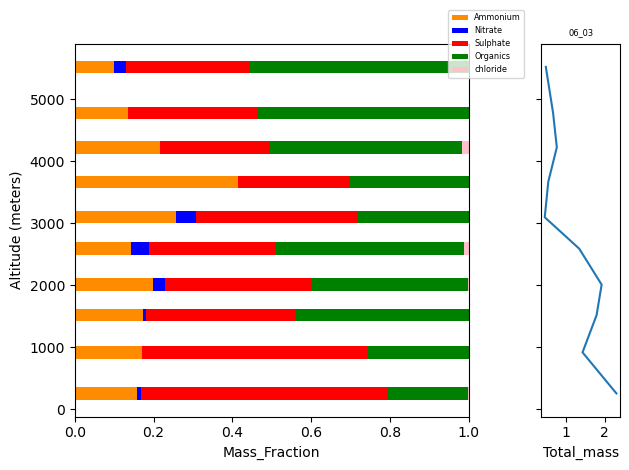

In [250]:
normal3 = (DAY3_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY3_subset_mean['AMS'] = normal3
DAY3_subset_mean = DAY3_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY3_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal3
y2 = DAY3_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal3
y3 = DAY3_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal3
y4 = DAY3_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal3
y5 = DAY3_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal3
y6 = DAY3_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal3
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY3_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal3, DAY3_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_03', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [321]:
DAY7 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L1_20230614T111635.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:48:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.990,0.940,0.086,0.069,0.008,0.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.990,0.940,0.086,0.069,0.008,0.245
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.990,0.940,0.086,0.069,0.008,0.245
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.990,0.940,0.086,0.069,0.008,0.245
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.990,0.940,0.086,0.069,0.008,0.245
...,...,...,...,...,...,...,...,...,...,...,...
11352,2022-06-07 14:47:55,2022-06-07 14:47:56,32.223583,-64.933389,3141.930,0.832,0.348,0.019,0.175,0.012,0.121
11353,2022-06-07 14:47:56,2022-06-07 14:47:57,32.222625,-64.932625,3139.810,0.832,0.348,0.019,0.175,0.012,0.121
11354,2022-06-07 14:47:57,2022-06-07 14:47:58,32.221687,-64.931820,3135.420,0.832,0.348,0.019,0.175,0.012,0.121
11355,2022-06-07 14:47:58,2022-06-07 14:47:59,32.220775,-64.930970,3129.020,0.832,0.348,0.019,0.175,0.012,0.121


In [322]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-07 14:34:56.385713920,2022-06-07 14:34:57.385714432,32.203638,-65.013275,547.907314,2.244800,1.061253,0.093264,0.552765,0.023254,0.306227
min,2022-06-07 14:32:05.300000,2022-06-07 14:32:06.300000,32.171059,-65.064003,134.321500,1.900000,0.978400,0.060000,0.149700,-0.010000,0.242000
25%,2022-06-07 14:33:33,2022-06-07 14:33:34,32.183532,-65.040326,342.408889,2.166909,1.007538,0.065643,0.449000,0.012921,0.283775
50%,2022-06-07 14:34:55.750000128,2022-06-07 14:34:56.750000128,32.199201,-65.010231,548.177226,2.300667,1.052115,0.088133,0.522000,0.019700,0.296500
75%,2022-06-07 14:36:22.624999936,2022-06-07 14:36:23.624999936,32.223384,-64.986411,752.343029,2.339769,1.082173,0.105423,0.666214,0.030000,0.334096
max,2022-06-07 14:37:45,2022-06-07 14:37:46,32.247173,-64.972478,956.276818,2.362000,1.214000,0.184000,0.834000,0.076000,0.372000
std,NaN,NaN,0.023566,0.029408,248.584584,0.120026,0.065861,0.032805,0.161576,0.020118,0.037417


In [323]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,70,70,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,2022-06-07 14:43:36.978571264,2022-06-07 14:43:37.978571520,32.220781,-65.012310,2056.140348,0.981492,0.441140,0.004499,0.216192,-0.007956,0.109385
min,2022-06-07 14:38:08.500000,2022-06-07 14:38:09.500000,32.162860,-65.063401,1014.855000,0.456000,0.131000,-0.093000,-0.270000,-0.047000,0.031000
25%,2022-06-07 14:41:03.624999936,2022-06-07 14:41:04.624999936,32.196278,-65.046322,1536.503958,0.654000,0.235000,-0.027000,0.004000,-0.026000,0.072000
50%,2022-06-07 14:44:04,2022-06-07 14:44:05,32.228920,-65.014092,2056.620750,0.972000,0.330000,0.014000,0.204167,-0.017000,0.103600
75%,2022-06-07 14:46:13.624999936,2022-06-07 14:46:14.624999936,32.247068,-64.983230,2575.380250,1.224929,0.418000,0.041500,0.366000,0.008750,0.150000
max,2022-06-07 14:47:45,2022-06-07 14:47:46,32.255156,-64.940854,3096.918000,1.648000,1.356000,0.088000,0.663000,0.043000,0.197000
std,NaN,NaN,0.029310,0.036146,613.900131,0.347498,0.347496,0.048598,0.253727,0.024861,0.045160


In [324]:
nbins = 10
bins7 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins7)
DAY7_subset_mean = DAY7_subset.groupby('Bins').mean()
DAY7_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(125.87, 427.476]",2022-06-07 14:33:02.483870976,2022-06-07 14:33:03.483870976,32.203817,-64.996724,274.828548,2.277710,1.038202,0.075500,0.582992,0.028129,0.306427
"(427.476, 729.082]",2022-06-07 14:35:09.000000000,2022-06-07 14:35:10.000000000,32.220244,-65.015191,578.601279,2.216837,1.016814,0.094837,0.473070,0.009721,0.333256
"(729.082, 1030.688]",2022-06-07 14:37:13.000000000,2022-06-07 14:37:14.000000000,32.189020,-65.036065,875.573571,2.162941,1.146739,0.107966,0.580067,0.029613,0.266664
"(1030.688, 1332.294]",2022-06-07 14:39:04.500000000,2022-06-07 14:39:05.500000000,32.241791,-65.017669,1176.122788,1.193288,1.187212,0.051481,0.534096,0.007346,0.132231
"(1332.294, 1633.9]",2022-06-07 14:40:48.000000000,2022-06-07 14:40:49.000000000,32.194630,-65.026493,1486.801845,1.499816,0.397903,0.031553,0.380583,0.024709,0.173039
"(1633.9, 1935.506]",2022-06-07 14:42:32.999999744,2022-06-07 14:42:34.000000000,32.240602,-65.014453,1783.392523,1.110234,0.188523,0.012692,0.176505,-0.022355,0.090589
"(1935.506, 2237.112]",2022-06-07 14:44:11.000000000,2022-06-07 14:44:12.000000000,32.182086,-64.981404,2082.471348,1.040157,0.264169,0.001640,0.164989,0.004191,0.063135
"(2237.112, 2538.718]",2022-06-07 14:45:31.000000000,2022-06-07 14:45:32.000000000,32.192505,-65.050238,2365.526197,0.565268,0.354380,-0.052775,0.331465,-0.022634,0.091817
"(2538.718, 2840.324]",2022-06-07 14:46:34.500000000,2022-06-07 14:46:35.500000000,32.246242,-65.023769,2690.086071,0.560464,0.263196,-0.026857,-0.128107,-0.036875,0.075625


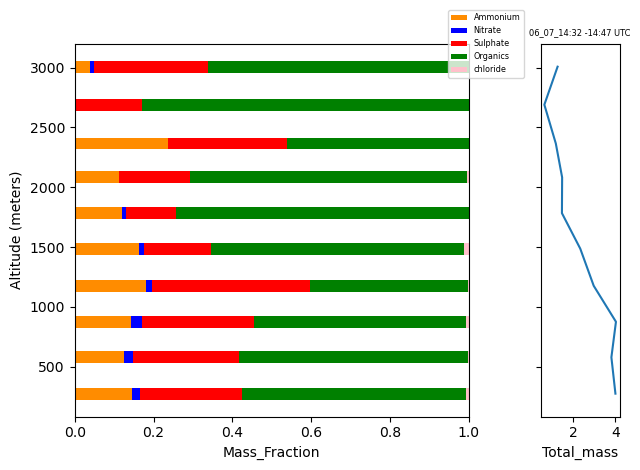

In [325]:
normal7 = (DAY7_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY7_subset_mean['AMS'] = normal7
DAY7_subset_mean = DAY7_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY7_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal7
y2 = DAY7_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal7
y3 = DAY7_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal7
y4 = DAY7_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal7
y5 = DAY7_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal7
y6 = DAY7_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal7
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 100, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 100, color = "blue", label = 'Nitrate')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 100, color = "red", label = 'Sulphate')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 100, color = "green", label = 'Organics')
#ax.barh(DAY7_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 100, color = "pink", label = 'chloride')
ax[1].plot(normal7, DAY7_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_07_14:32 -14:47 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [256]:
DAY7b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L2_20230614T111635.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077
...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148


In [257]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,24,24,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2022-06-07 19:10:10.073529344,2022-06-07 19:10:11.073529088,32.266668,-65.007084,541.993433,0.976279,0.601397,0.065631,0.139755,0.003925,0.096298
min,2022-06-07 19:08:08.764705792,2022-06-07 19:08:09.764706048,32.234380,-65.053370,142.995294,0.743000,0.449000,0.013000,-0.006000,-0.033000,0.066000
25%,2022-06-07 19:09:09.375000064,2022-06-07 19:09:10.375000064,32.247399,-65.033467,345.866146,0.905975,0.513773,0.040000,0.051833,-0.008000,0.076500
50%,2022-06-07 19:10:12.249999872,2022-06-07 19:10:13.249999872,32.265216,-64.998511,542.307523,0.981000,0.571700,0.061709,0.146455,0.002676,0.094227
75%,2022-06-07 19:11:09.500000,2022-06-07 19:11:10.500000,32.283971,-64.980836,738.611174,1.021636,0.619139,0.106000,0.234500,0.011652,0.115000
max,2022-06-07 19:12:08,2022-06-07 19:12:09,32.302506,-64.972311,935.982778,1.213000,0.891000,0.136000,0.278000,0.044000,0.141000
std,NaN,NaN,0.022943,0.029019,241.840005,0.131483,0.129446,0.038919,0.096325,0.021377,0.023202


In [258]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,73,73,73.000000,73.000000,73.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,2022-06-07 19:18:29.986301184,2022-06-07 19:18:30.986301440,32.257889,-65.013035,2231.494696,0.713215,0.308433,0.030655,0.248259,0.016204,0.087679
min,2022-06-07 19:12:28.500000,2022-06-07 19:12:29.500000,32.216667,-65.060683,1003.411000,0.226000,0.098000,-0.037000,-0.067000,-0.035000,0.000000
25%,2022-06-07 19:15:47,2022-06-07 19:15:48,32.232928,-65.040904,1617.601818,0.491500,0.146000,0.010667,0.065000,0.003231,0.026000
50%,2022-06-07 19:19:20,2022-06-07 19:19:21,32.257599,-65.010363,2230.995455,0.596000,0.237000,0.037000,0.208000,0.018000,0.080727
75%,2022-06-07 19:21:12.500000,2022-06-07 19:21:13.500000,32.283190,-64.983953,2846.185000,0.914000,0.300000,0.057727,0.482750,0.028000,0.123000
max,2022-06-07 19:22:46,2022-06-07 19:22:47,32.300554,-64.969690,3459.904000,1.590000,1.295000,0.108000,0.563000,0.045000,0.239000
std,NaN,NaN,0.026111,0.029529,724.229273,0.374971,0.302657,0.037189,0.214246,0.019562,0.063048


In [259]:
nbins = 10
bins7b = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins7b)
DAY7b_subset_mean = DAY7b_subset.groupby('Bins').mean()
DAY7b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.595, 473.926]",2022-06-07 19:08:55.463636480,2022-06-07 19:08:56.463636224,32.279306,-64.993026,296.716545,0.936445,0.515709,0.056945,0.184218,0.007791,0.091273
"(473.926, 815.256]",2022-06-07 19:10:40.500000000,2022-06-07 19:10:41.500000000,32.254455,-65.033104,640.184650,0.953800,0.592030,0.068560,0.147130,0.007920,0.096250
"(815.256, 1156.586]",2022-06-07 19:12:23.500000000,2022-06-07 19:12:24.500000000,32.282477,-65.003299,986.855849,1.388519,1.069896,0.071330,0.136642,-0.006340,0.168613
"(1156.586, 1497.917]",2022-06-07 19:14:12.500000000,2022-06-07 19:14:13.500000000,32.247663,-65.028547,1322.901607,0.917804,0.391482,0.032929,0.290705,0.028116,0.118429
"(1497.917, 1839.248]",2022-06-07 19:16:05.500000000,2022-06-07 19:16:06.500000000,32.279859,-65.022303,1673.998596,0.590000,0.266000,0.046000,0.017000,0.000000,0.096000
"(1839.248, 2180.578]",2022-06-07 19:18:01.999999744,2022-06-07 19:18:03.000000000,32.241752,-65.004495,2004.607647,0.594453,0.212509,0.031236,0.071962,-0.001868,0.101943
"(2180.578, 2521.908]",2022-06-07 19:19:42.000000000,2022-06-07 19:19:43.000000000,32.278778,-65.019786,2318.329012,0.517086,0.175531,0.064086,0.090111,0.006000,0.031420
"(2521.908, 2863.239]",2022-06-07 19:20:49.000000000,2022-06-07 19:20:50.000000000,32.227765,-65.035262,2691.864151,0.770906,0.253962,0.048887,0.554321,0.028000,0.103906
"(2863.239, 3204.57]",2022-06-07 19:21:41.000000000,2022-06-07 19:21:42.000000000,32.235981,-64.983314,3033.278039,0.696725,0.203294,0.010118,0.208157,0.028588,0.080824


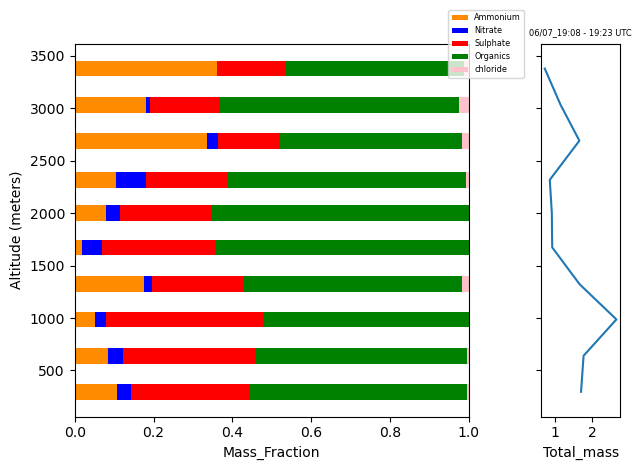

In [260]:
normal7b = (DAY7b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY7b_subset_mean['AMS'] = normal7b
DAY7b_subset_mean = DAY7b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY7b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal7b
y2 = DAY7b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal7b
y3 = DAY7b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal7b
y4 = DAY7b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal7b
y5 = DAY7b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal7b
y6 = DAY7b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal7b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal7b, DAY7b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/07_19:08 - 19:23 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [261]:
DAY8 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220608_R0_L2_20230614T111636.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169
...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050


In [262]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,22,22,22.000000,22.000000,22.000000,22.000000,22.000000,22.00000,22.000000,22.000000,22.000000
mean,2022-06-08 20:32:55.875598080,2022-06-08 20:32:56.875598080,32.280714,-65.050261,556.617178,0.871977,1.366537,0.03100,0.150281,-0.004818,0.119464
min,2022-06-08 20:30:28.263158016,2022-06-08 20:30:29.263158016,32.240992,-65.089810,156.621053,0.467000,1.194088,-0.02500,-0.183000,-0.030000,0.076000
25%,2022-06-08 20:31:57,2022-06-08 20:31:58,32.255180,-65.076734,361.598875,0.864750,1.308000,0.00730,-0.013500,-0.010659,0.098100
50%,2022-06-08 20:32:55.249999872,2022-06-08 20:32:56.249999872,32.283625,-65.054096,557.482614,0.898800,1.338000,0.03560,0.210100,-0.006000,0.118500
75%,2022-06-08 20:33:58.750000128,2022-06-08 20:33:59.750000128,32.302411,-65.021867,752.755000,0.995846,1.393405,0.05500,0.313423,0.002000,0.136462
max,2022-06-08 20:34:59,2022-06-08 20:35:00,32.321613,-65.006859,947.486818,1.078930,1.635000,0.06100,0.358000,0.020386,0.168000
std,NaN,NaN,0.027820,0.029324,242.789874,0.168146,0.122852,0.02702,0.182231,0.013684,0.025818


In [263]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,66,66,66.000000,66.000000,66.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,2022-06-08 20:40:35.712121088,2022-06-08 20:40:36.712120832,32.267574,-65.045738,2233.285641,0.650548,0.405310,0.004318,0.185304,0.011657,0.088949
min,2022-06-08 20:35:22,2022-06-08 20:35:23,32.228886,-65.089712,1020.976364,0.111000,0.207000,-0.091000,-0.058000,-0.037000,-0.020000
25%,2022-06-08 20:38:33.750000128,2022-06-08 20:38:34.750000128,32.248320,-65.066839,1629.684000,0.305000,0.253000,-0.029000,0.041000,0.002000,0.047000
50%,2022-06-08 20:40:58,2022-06-08 20:40:59,32.268545,-65.043980,2235.469949,0.699000,0.296833,0.011000,0.173000,0.013000,0.089000
75%,2022-06-08 20:42:54.375000064,2022-06-08 20:42:55.375000064,32.288503,-65.022374,2837.283250,0.944000,0.412000,0.031000,0.311000,0.023000,0.129000
max,2022-06-08 20:44:08.500000,2022-06-08 20:44:09.500000,32.305375,-65.008625,3442.207500,1.288000,1.567000,0.095000,0.438000,0.064000,0.212000
std,NaN,NaN,0.022907,0.024482,714.895116,0.368639,0.322918,0.040986,0.146447,0.021238,0.060320


In [264]:
nbins = 10
bins8 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins8)
DAY8_subset_mean = DAY8_subset.groupby('Bins').mean()
DAY8_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(147.455, 519.956]",2022-06-08 20:31:21.742331392,2022-06-08 20:31:22.742331392,32.276046,-65.056034,276.520460,0.893344,1.292276,0.039515,0.071117,0.000313,0.117724
"(519.956, 892.456]",2022-06-08 20:33:42.500000000,2022-06-08 20:33:43.500000000,32.287537,-65.024766,704.982331,0.925297,1.341076,0.023195,0.252966,-0.001263,0.135780
"(892.456, 1264.956]",2022-06-08 20:35:41.500000000,2022-06-08 20:35:42.500000000,32.272044,-65.062549,1078.632625,1.152124,1.375000,0.024640,0.280809,0.019270,0.136517
"(1264.956, 1637.457]",2022-06-08 20:37:38.500000000,2022-06-08 20:37:39.500000000,32.289518,-65.042268,1425.389298,1.037009,0.313982,-0.006009,0.039289,0.015667,0.110228
"(1637.457, 2009.958]",2022-06-08 20:39:21.500000000,2022-06-08 20:39:22.499999744,32.248989,-65.037528,1824.238696,0.420804,0.283152,0.028174,0.170174,0.005196,0.051174
"(2009.958, 2382.458]",2022-06-08 20:40:49.000000000,2022-06-08 20:40:50.000000000,32.285274,-65.049764,2191.881205,0.677663,0.404952,0.021458,0.191313,0.019675,0.086795
"(2382.458, 2754.958]",2022-06-08 20:42:07.000000000,2022-06-08 20:42:08.000000000,32.240255,-65.068783,2547.902329,0.829740,0.376616,0.036918,0.194589,-0.009904,0.140548
"(2754.958, 3127.459]",2022-06-08 20:43:07.000000000,2022-06-08 20:43:08.000000256,32.258438,-65.020265,2939.163191,0.443553,0.252426,-0.022830,0.382596,0.019574,0.089809
"(3127.459, 3499.96]",2022-06-08 20:43:53.000000000,2022-06-08 20:43:54.000000000,32.293392,-65.047322,3311.822889,0.154378,0.244111,-0.038244,0.032822,0.015133,0.019467


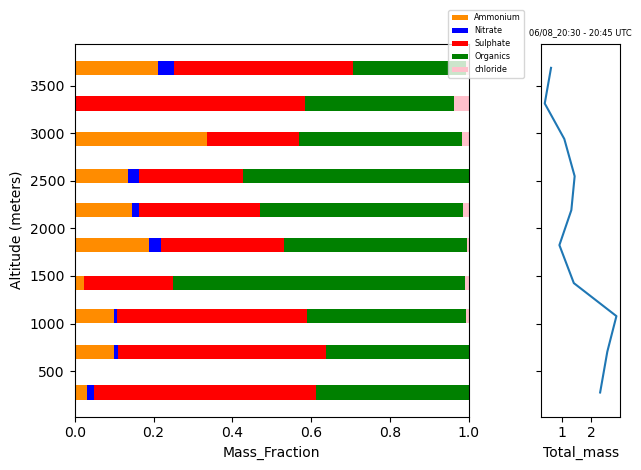

In [265]:
normal8 = (DAY8_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY8_subset_mean['AMS'] = normal8
DAY8_subset_mean = DAY8_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY8_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal8
y2 = DAY8_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal8
y3 = DAY8_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal8
y4 = DAY8_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal8
y5 = DAY8_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal8
y6 = DAY8_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal8
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal8, DAY8_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/08_20:30 - 20:45 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [266]:
DAY10 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L1_20230614T111636.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023
...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027


In [267]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,24,24,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2022-06-10 15:18:37.479166720,2022-06-10 15:18:38.479166720,32.289081,-65.050463,534.617324,0.378214,1.124800,0.010600,0.272345,-0.003523,0.024393
min,2022-06-10 15:17:25,2022-06-10 15:17:26,32.234724,-65.101786,124.887449,0.292000,0.887776,-0.036000,0.013102,-0.013000,-0.015306
25%,2022-06-10 15:18:15.375000064,2022-06-10 15:18:16.375000064,32.284812,-65.078581,340.319687,0.309667,1.039000,-0.015000,0.198000,-0.009000,-0.007000
50%,2022-06-10 15:18:39.249999872,2022-06-10 15:18:40.249999872,32.293738,-65.048833,536.140000,0.334000,1.123000,0.024000,0.306000,-0.007583,0.014000
75%,2022-06-10 15:19:02.500000,2022-06-10 15:19:03.500000,32.299473,-65.021756,730.602812,0.397000,1.148000,0.027500,0.308000,0.004000,0.051000
max,2022-06-10 15:19:25.500000,2022-06-10 15:19:26.500000,32.301621,-65.001980,930.682500,0.826000,1.560000,0.064816,0.490000,0.014122,0.093000
std,NaN,NaN,0.015246,0.032410,243.092100,0.128824,0.132560,0.024102,0.090605,0.008330,0.030678


In [268]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,72,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2022-06-10 15:22:02.215277824,2022-06-10 15:22:03.215277568,32.251439,-65.054574,2223.082150,0.498595,0.650756,0.026150,0.156290,-0.007275,0.074615
min,2022-06-10 15:19:33.500000,2022-06-10 15:19:34.500000,32.210307,-65.111207,1001.980000,0.112000,0.202000,-0.036000,-0.175000,-0.039000,0.013000
25%,2022-06-10 15:20:44.375000064,2022-06-10 15:20:45.375000064,32.222557,-65.087411,1611.434250,0.302750,0.279750,0.005500,0.009900,-0.030000,0.024000
50%,2022-06-10 15:21:59.500000,2022-06-10 15:22:00.500000,32.247506,-65.062042,2224.210000,0.471000,0.435000,0.035000,0.178000,-0.001000,0.084000
75%,2022-06-10 15:23:18.124999936,2022-06-10 15:23:19.124999936,32.276805,-65.017379,2834.650250,0.776000,1.155000,0.043125,0.339000,0.008125,0.115000
max,2022-06-10 15:24:42.500000,2022-06-10 15:24:43.500000,32.302508,-64.988930,3448.995000,0.861000,1.560000,0.067000,0.490000,0.034000,0.128000
std,NaN,NaN,0.030859,0.040500,721.007276,0.238282,0.440849,0.028954,0.200801,0.021214,0.040976


In [269]:
nbins = 10
bins10 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins10)
DAY10_subset_mean = DAY10_subset.groupby('Bins').mean()
DAY10_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(122.04, 466.509]",2022-06-10 15:17:45.500,2022-06-10 15:17:46.500000000,32.256412,-65.009692,205.705000,0.316222,0.991556,0.043222,0.144000,0.004111,-0.009222
"(466.509, 810.978]",2022-06-10 15:18:51.000,2022-06-10 15:18:52.000000000,32.299716,-65.063853,634.627927,0.366268,1.082024,0.004976,0.251659,-0.002659,0.032951
"(810.978, 1155.447]",2022-06-10 15:19:31.000,2022-06-10 15:19:32.000000000,32.277402,-65.103720,979.658846,0.727897,1.452205,-0.021564,0.417718,0.005462,0.084205
"(1155.447, 1499.916]",2022-06-10 15:20:10.500,2022-06-10 15:20:11.500000000,32.236081,-65.102113,1326.291500,0.837625,1.252150,0.000200,0.316325,-0.001775,0.127450
"(1499.916, 1844.385]",2022-06-10 15:20:51.500,2022-06-10 15:20:52.500000000,32.213377,-65.056119,1670.304048,0.542167,0.950738,0.042119,0.349405,-0.024119,0.086571
"(1844.385, 2188.854]",2022-06-10 15:21:34.000,2022-06-10 15:21:35.000000000,32.233316,-65.003295,2023.057209,0.430395,0.600209,0.014465,0.178558,-0.032442,0.069907
"(2188.854, 2533.323]",2022-06-10 15:22:16.500,2022-06-10 15:22:17.500000000,32.279634,-64.997803,2363.169286,0.303714,0.369429,0.033286,0.129429,0.014000,0.016429
"(2533.323, 2877.792]",2022-06-10 15:23:00.500,2022-06-10 15:23:01.500000256,32.299165,-65.046415,2703.850217,0.552261,0.351000,0.015565,0.040609,0.013087,0.089261
"(2877.792, 3222.261]",2022-06-10 15:23:48.000,2022-06-10 15:23:49.000000000,32.263147,-65.085278,3042.873061,0.348653,0.244837,0.052265,-0.058592,-0.024163,0.064857


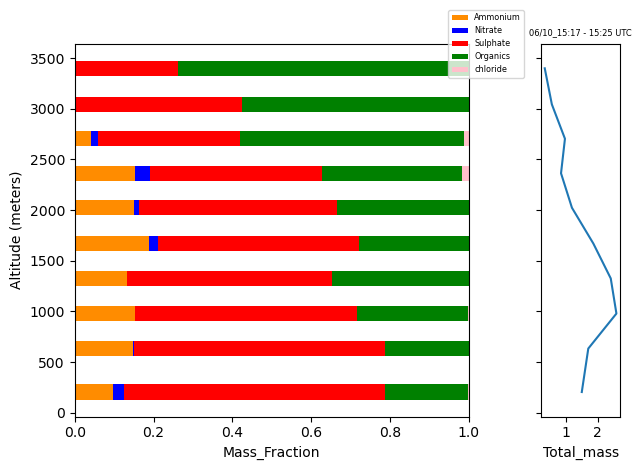

In [270]:
normal10 = (DAY10_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY10_subset_mean['AMS'] = normal10
DAY10_subset_mean = DAY10_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY10_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal10
y2 = DAY10_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal10
y3 = DAY10_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal10
y4 = DAY10_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal10
y5 = DAY10_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal10
y6 = DAY10_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal10
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal10, DAY10_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/10_15:17 - 15:25 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [271]:
DAY110b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY110b[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026
...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.435,0.137,-0.020,0.518,-0.031,0.045
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.435,0.137,-0.020,0.518,-0.031,0.045
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.435,0.137,-0.020,0.518,-0.031,0.045
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.435,0.137,-0.020,0.518,-0.031,0.045


In [272]:
nbins = 10
bins10b = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins10b)
DAY110b_subset_mean = DAY110b_subset.groupby('Bins').mean()
DAY110b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(112.97, 601.145]",2022-06-10 19:32:59.991643648,2022-06-10 19:33:00.991643392,31.735367,-65.783676,177.143162,0.356663,1.388318,0.045373,0.339850,0.002574,0.024056
"(601.145, 1089.32]",2022-06-10 19:36:45.500000000,2022-06-10 19:36:46.500000000,31.841334,-65.835806,838.542446,0.310924,1.256261,0.032402,0.615609,0.003022,0.013326
"(1089.32, 1577.495]",2022-06-10 19:38:13.000000000,2022-06-10 19:38:14.000000000,31.844149,-65.864833,1314.286988,0.449747,1.290578,-0.010169,0.452470,-0.010253,0.063747
"(1577.495, 2065.67]",2022-06-10 19:39:36.000000000,2022-06-10 19:39:37.000000000,31.835484,-65.816107,1833.345904,0.444964,1.142542,0.029108,0.285229,0.006157,0.114759
"(2065.67, 2553.845]",2022-06-10 19:40:57.500000000,2022-06-10 19:40:58.500000000,31.834687,-65.863397,2318.241000,0.966212,0.748250,0.042875,0.145587,0.005000,0.178912
"(2553.845, 3042.02]",2022-06-10 19:42:19.500000000,2022-06-10 19:42:20.500000000,31.850763,-65.807532,2799.071667,0.732964,0.400429,0.028357,0.208464,-0.032214,0.143250
"(3042.02, 3530.195]",2022-06-10 19:43:36.000000000,2022-06-10 19:43:37.000000000,31.775850,-65.805184,3284.576812,0.278623,0.126130,-0.026043,-0.081725,-0.045942,0.020783
"(3530.195, 4018.37]",2022-06-10 19:44:34.000000000,2022-06-10 19:44:35.000000000,31.712293,-65.821955,3755.635532,0.424404,0.136255,-0.031234,0.035170,-0.018340,0.025064
"(4018.37, 4506.545]",2022-06-10 19:45:21.000000000,2022-06-10 19:45:22.000000000,31.662256,-65.838271,4269.792553,0.435426,0.142170,-0.019574,0.074936,-0.013298,0.034383


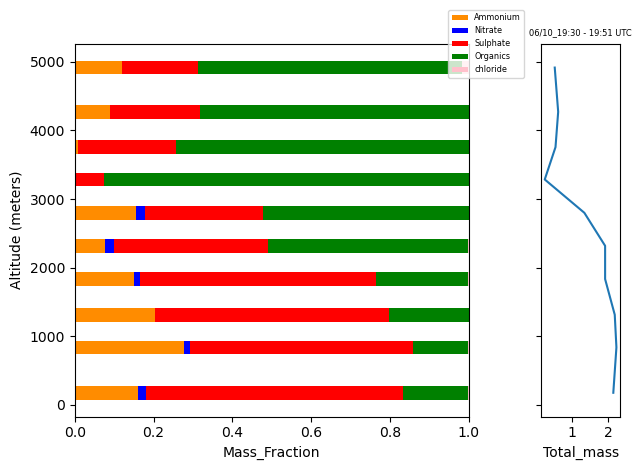

In [273]:
normal10b = (DAY110b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY110b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY110b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY110b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY110b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY110b_subset_mean['AMS'] = normal8
DAY110b_subset_mean = DAY110b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY110b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal10b
y2 = DAY110b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal10b
y3 = DAY110b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal10b
y4 = DAY110b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal10b
y5 = DAY110b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal10b
y6 = DAY110b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal10b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY110b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal10b, DAY110b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/10_19:30 - 19:51 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [274]:
DAY10b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset = DAY10b_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,0.316,1.072,-0.011,0.461,0.038,0.078
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,0.316,1.072,-0.011,0.461,0.038,0.078
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,0.316,1.072,-0.011,0.461,0.038,0.078
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,0.316,1.072,-0.011,0.461,0.038,0.078
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,0.316,1.072,-0.011,0.461,0.038,0.078
...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.361,0.126,-0.036,-0.021,0.059,0.056
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.361,0.126,-0.036,-0.021,0.059,0.056
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.361,0.126,-0.036,-0.021,0.059,0.056
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.361,0.126,-0.036,-0.021,0.059,0.056


In [275]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,17,17,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2022-06-10 20:27:15.000824576,2022-06-10 20:27:16.000824320,31.320787,-65.807238,528.773226,0.245207,1.252636,0.082087,0.440658,-0.037382,-0.000022
min,2022-06-10 20:25:53.514018560,2022-06-10 20:25:54.514018560,31.246519,-65.851338,129.908178,0.205000,1.119000,0.033308,0.400000,-0.070000,-0.017000
25%,2022-06-10 20:27:02,2022-06-10 20:27:03,31.307850,-65.812080,334.144000,0.205000,1.190000,0.075000,0.400000,-0.070000,-0.017000
50%,2022-06-10 20:27:18.500000,2022-06-10 20:27:19.500000,31.326329,-65.802565,525.013750,0.242500,1.190000,0.083667,0.419000,-0.039000,0.003000
75%,2022-06-10 20:27:34.999999744,2022-06-10 20:27:36,31.340740,-65.797477,723.933333,0.280000,1.417000,0.104000,0.486000,-0.039000,0.003000
max,2022-06-10 20:27:46.999999744,2022-06-10 20:27:48,31.345458,-65.795880,916.443333,0.305000,1.417000,0.104000,0.573850,0.027000,0.045000
std,NaN,NaN,0.025557,0.014040,244.799281,0.039195,0.115866,0.023855,0.051059,0.031754,0.020106


In [276]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,51,51,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,2022-06-10 20:29:26.068627712,2022-06-10 20:29:27.068627456,31.329672,-65.801464,2215.097261,0.477087,0.690234,0.038784,0.284686,-0.017265,0.043209
min,2022-06-10 20:27:53.000000256,2022-06-10 20:27:54,31.296741,-65.852530,1010.093333,0.299000,0.089000,-0.019000,-0.055000,-0.066000,-0.047000
25%,2022-06-10 20:28:33.249999872,2022-06-10 20:28:34.249999872,31.306478,-65.840567,1612.194500,0.417250,0.245250,0.021000,0.176000,-0.052000,0.008000
50%,2022-06-10 20:29:29.500000,2022-06-10 20:29:30.500000,31.328227,-65.793186,2217.282500,0.526000,0.639000,0.037000,0.356000,-0.009000,0.045000
75%,2022-06-10 20:30:13.500000,2022-06-10 20:30:14.500000,31.344958,-65.764928,2819.603750,0.557000,1.114833,0.057000,0.397375,0.027000,0.084000
max,2022-06-10 20:31:03.500000,2022-06-10 20:31:04.500000,31.382418,-65.754401,3419.872500,0.600000,1.193000,0.103000,0.546000,0.033000,0.103000
std,NaN,NaN,0.025780,0.037499,715.665634,0.107813,0.420936,0.036647,0.176625,0.037787,0.049175


In [277]:
nbins = 10
bins10b = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins10b)
DAY10b_subset_mean = DAY10b_subset.groupby('Bins').mean()
DAY10b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(119.575, 601.128]",2022-06-10 20:26:12.641379328,2022-06-10 20:26:13.641379328,31.263946,-65.837483,196.974069,0.245228,1.214269,0.047034,0.542524,-0.011662,0.011372
"(601.128, 1082.682]",2022-06-10 20:27:41.500000000,2022-06-10 20:27:42.500000000,31.342366,-65.816305,830.902969,0.255000,1.154500,0.073500,0.409500,-0.006000,0.014000
"(1082.682, 1564.236]",2022-06-10 20:28:13.000000000,2022-06-10 20:28:14.000000000,31.336316,-65.845786,1321.829355,0.432226,1.116258,0.075903,0.384452,0.030290,0.076806
"(1564.236, 2045.789]",2022-06-10 20:28:51.500000000,2022-06-10 20:28:52.500000000,31.306551,-65.838239,1806.783043,0.554152,1.134543,0.054609,0.481152,0.000065,0.082913
"(2045.789, 2527.342]",2022-06-10 20:29:32.500000000,2022-06-10 20:29:33.500000000,31.301833,-65.789881,2267.442778,0.581500,0.609000,0.011000,0.325250,-0.055500,0.032250
"(2527.342, 3008.896]",2022-06-10 20:30:10.500000000,2022-06-10 20:30:11.500000000,31.332590,-65.758200,2777.024750,0.418175,0.345625,0.017100,0.186450,-0.056975,0.021775
"(3008.896, 3490.449]",2022-06-10 20:30:50.500000000,2022-06-10 20:30:51.500000000,31.373148,-65.769792,3250.567500,0.422000,0.105250,0.036000,0.008250,-0.011750,-0.011000
"(3490.449, 3972.003]",2022-06-10 20:31:30.500000000,2022-06-10 20:31:31.500000000,31.371120,-65.811585,3703.877250,0.312250,0.111250,-0.025250,0.154500,0.011500,0.009250
"(3972.003, 4453.556]",2022-06-10 20:32:21.000000000,2022-06-10 20:32:22.000000000,31.334070,-65.793165,4250.171311,0.249754,0.080295,-0.024361,-0.006557,0.005377,0.012508


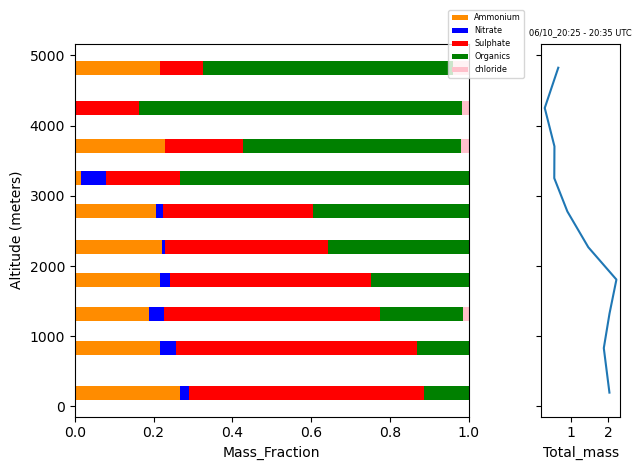

In [278]:
normal10b = (DAY10b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY10b_subset_mean['AMS'] = normal8
DAY10b_subset_mean = DAY10b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY10b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal10b
y2 = DAY10b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal10b
y3 = DAY10b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal10b
y4 = DAY10b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal10b
y5 = DAY10b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal10b
y6 = DAY10b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal10b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal10b, DAY10b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/10_20:25 - 20:35 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [279]:
DAY11 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L1_20230614T111637.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006


In [280]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,18,18,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2022-06-11 15:27:20.118326272,2022-06-11 15:27:21.118325760,32.220720,-65.007791,548.346459,0.275848,0.852107,0.005138,0.251248,-0.000054,-0.011053
min,2022-06-11 15:24:38.129870080,2022-06-11 15:24:39.129870080,32.197496,-65.036850,141.553312,0.047000,0.575200,-0.058000,0.100000,-0.015000,-0.041091
25%,2022-06-11 15:26:32.375000064,2022-06-11 15:26:33.375000064,32.203415,-65.029359,355.942229,0.119063,0.654071,-0.028850,0.191000,-0.009288,-0.022013
50%,2022-06-11 15:27:35,2022-06-11 15:27:36,32.217243,-65.012114,551.257875,0.237731,0.691950,0.011500,0.256017,-0.007000,-0.014000
75%,2022-06-11 15:28:16,2022-06-11 15:28:17,32.237348,-64.988460,748.522619,0.490000,1.079708,0.029224,0.325932,0.004861,-0.008000
max,2022-06-11 15:29:05,2022-06-11 15:29:06,32.252484,-64.971716,932.450333,0.497000,1.462026,0.100533,0.369000,0.043867,0.038000
std,NaN,NaN,0.019598,0.022669,246.508119,0.176960,0.273721,0.045128,0.088837,0.017152,0.018378


In [281]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,53,53,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,2022-06-11 15:34:51.264150784,2022-06-11 15:34:52.264151040,32.238715,-64.995622,2225.360581,0.213176,0.398190,-0.003329,0.157909,0.001084,0.006248
min,2022-06-11 15:29:30.500000,2022-06-11 15:29:31.500000,32.200188,-65.044243,1035.389286,-0.050000,0.144000,-0.076000,-0.245000,-0.052000,-0.048000
25%,2022-06-11 15:32:17,2022-06-11 15:32:18,32.217349,-65.018397,1625.907778,0.117231,0.189000,-0.011000,0.056333,-0.007273,-0.022000
50%,2022-06-11 15:35:29,2022-06-11 15:35:30,32.237558,-64.994723,2225.388889,0.260000,0.429800,-0.000500,0.193000,0.001000,0.017000
75%,2022-06-11 15:37:29,2022-06-11 15:37:30,32.261265,-64.974320,2823.684000,0.322000,0.532000,0.018800,0.280429,0.012769,0.028000
max,2022-06-11 15:38:57.500000,2022-06-11 15:38:58.500000,32.285639,-64.950412,3416.133333,0.358000,0.775000,0.052000,0.521000,0.044652,0.050000
std,NaN,NaN,0.024757,0.027528,708.226527,0.123889,0.190357,0.032836,0.175808,0.018952,0.030271


In [282]:
nbins = 10
bins11 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins11)
DAY11_subset_mean = DAY11_subset.groupby('Bins').mean()
DAY11_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(137.295, 596.256]",2022-06-11 15:25:52.702222336,2022-06-11 15:25:53.702222080,32.219438,-64.998848,286.423489,0.236738,1.168484,0.002262,0.296320,-0.001827,-0.003009
"(596.256, 1055.218]",2022-06-11 15:28:41.500000000,2022-06-11 15:28:42.500000000,32.228795,-65.015158,845.452321,0.327036,0.597509,0.035223,0.254473,0.009402,-0.016375
"(1055.218, 1514.18]",2022-06-11 15:30:37.500000000,2022-06-11 15:30:38.500000000,32.220438,-64.995039,1269.931250,0.261717,0.621417,-0.010383,0.218608,-0.002083,-0.001917
"(1514.18, 1973.141]",2022-06-11 15:32:49.500000000,2022-06-11 15:32:50.500000000,32.241553,-65.007040,1736.124514,0.089313,0.548854,-0.014188,0.143146,0.010063,-0.018729
"(1973.141, 2432.102]",2022-06-11 15:35:07.500000000,2022-06-11 15:35:08.500000000,32.265972,-65.002925,2173.202045,0.246364,0.459159,0.010682,0.275318,0.013091,0.013659
"(2432.102, 2891.064]",2022-06-11 15:36:55.000000000,2022-06-11 15:36:56.000000000,32.212340,-64.973233,2642.450723,0.206554,0.216157,-0.003410,-0.101337,0.006446,-0.015940
"(2891.064, 3350.026]",2022-06-11 15:38:13.000000000,2022-06-11 15:38:14.000000000,32.248050,-65.008491,3126.077671,0.207973,0.192918,0.012233,0.156096,-0.005096,0.039521
"(3350.026, 3808.987]",2022-06-11 15:39:21.000000000,2022-06-11 15:39:22.000000000,32.237354,-64.956286,3577.126190,0.448889,0.209444,-0.050460,0.313921,-0.009794,0.008238
"(3808.987, 4267.948]",2022-06-11 15:40:21.000000256,2022-06-11 15:40:22.000000000,32.208927,-65.006624,4039.932632,0.384912,0.197632,-0.000368,0.054439,0.009070,0.009491


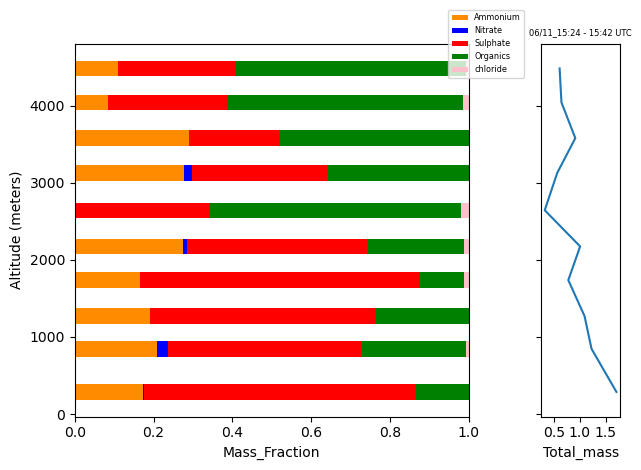

In [283]:
normal11 = (DAY11_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY11_subset_mean['AMS'] = normal11
DAY11_subset_mean = DAY11_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY11_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal11
y2 = DAY11_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal11
y3 = DAY11_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal11
y4 = DAY11_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal11
y5 = DAY11_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal11
y6 = DAY11_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal11
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal11, DAY11_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06/11_15:24 - 15:42 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [316]:
DAY11b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L2_20230614T111637.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,0.070,0.988,0.055,0.232,-0.004,0.018
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,0.070,0.988,0.055,0.232,-0.004,0.018
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,0.070,0.988,0.055,0.232,-0.004,0.018
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,0.070,0.988,0.055,0.232,-0.004,0.018
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,0.070,0.988,0.055,0.232,-0.004,0.018
...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.293,0.322,-0.059,0.119,0.006,-0.012
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.293,0.322,-0.059,0.119,0.006,-0.012
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.293,0.322,-0.059,0.119,0.006,-0.012
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,0.293,0.322,-0.059,0.119,0.006,-0.012


In [317]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-11 20:09:10.799107328,2022-06-11 20:09:11.799107328,31.243017,-64.678417,534.532948,0.388767,0.931577,0.007770,0.271938,0.012980,0.038655
min,2022-06-11 20:08:07.875000064,2022-06-11 20:08:08.875000064,31.219407,-64.702319,119.087500,0.070000,0.847000,-0.033000,-0.024000,-0.004000,0.000000
25%,2022-06-11 20:08:39.750000128,2022-06-11 20:08:40.750000128,31.225295,-64.694994,327.115500,0.279000,0.893000,-0.018000,0.044500,0.011000,0.018000
50%,2022-06-11 20:09:12,2022-06-11 20:09:13,31.245295,-64.677789,535.346333,0.416000,0.950750,0.025083,0.356000,0.013000,0.028000
75%,2022-06-11 20:09:41.875000320,2022-06-11 20:09:42.875000064,31.258214,-64.663807,739.427187,0.501750,0.970000,0.033000,0.396000,0.015000,0.066375
max,2022-06-11 20:10:10,2022-06-11 20:10:11,31.265189,-64.649837,946.674000,0.549000,1.027000,0.055000,0.510000,0.026000,0.081000
std,NaN,NaN,0.016541,0.017246,250.829203,0.148703,0.061333,0.031539,0.194263,0.007824,0.030698


In [318]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,70,70,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,2022-06-11 20:12:34.115419392,2022-06-11 20:12:35.115419392,31.244998,-64.679150,2058.764810,0.219868,0.482736,-0.014783,0.098289,0.011003,0.008002
min,2022-06-11 20:10:20.500000,2022-06-11 20:10:21.500000,31.221701,-64.708958,1007.378750,-0.081000,0.310000,-0.097000,-0.227000,-0.016000,-0.034000
25%,2022-06-11 20:11:21,2022-06-11 20:11:22,31.229074,-64.700483,1532.465667,0.169750,0.320298,-0.035929,-0.007866,-0.010000,-0.019000
50%,2022-06-11 20:12:28.500000,2022-06-11 20:12:29.500000,31.244880,-64.679490,2057.026250,0.254000,0.381000,0.003000,0.080000,0.011000,0.000000
75%,2022-06-11 20:13:40.500000,2022-06-11 20:13:41.500000,31.257724,-64.658015,2585.137500,0.348000,0.708083,0.008937,0.252250,0.017000,0.031000
max,2022-06-11 20:14:58.000000256,2022-06-11 20:14:59,31.274808,-64.641436,3109.385714,0.501000,1.027000,0.033000,0.510000,0.064000,0.066000
std,NaN,NaN,0.016815,0.021688,620.174231,0.153229,0.184449,0.039356,0.165180,0.022493,0.030007


In [319]:
nbins = 10
bins11b = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins11b)
DAY11b_subset_men = DAY11b_subset.groupby('Bins').mean()
DAY11b_subset_men

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(108.925, 413.609]",2022-06-11 20:08:24.795918336,2022-06-11 20:08:25.795918080,31.222734,-64.669874,224.298571,0.246531,0.971673,0.041735,0.101388,0.003653,0.023102
"(413.609, 718.294]",2022-06-11 20:09:14.500000000,2022-06-11 20:09:15.500000000,31.251960,-64.694545,559.355300,0.373700,0.885500,-0.017800,0.342000,0.014000,0.027100
"(718.294, 1022.978]",2022-06-11 20:10:01.000000000,2022-06-11 20:10:02.000000000,31.249292,-64.659381,878.454302,0.516628,0.968395,0.011512,0.459860,0.021767,0.070884
"(1022.978, 1327.663]",2022-06-11 20:10:39.500000000,2022-06-11 20:10:40.500000000,31.224062,-64.679422,1180.174412,0.247735,0.738559,0.004765,0.268000,-0.007706,-0.014676
"(1327.663, 1632.347]",2022-06-11 20:11:15.000000000,2022-06-11 20:11:16.000000000,31.246270,-64.705961,1486.265946,-0.001541,0.677973,0.014595,0.240946,0.023892,-0.014378
"(1632.347, 1937.032]",2022-06-11 20:11:54.500000000,2022-06-11 20:11:55.500000000,31.270944,-64.677367,1797.411905,0.069000,0.485500,0.013500,0.143000,0.024000,0.011000
"(1937.032, 2241.716]",2022-06-11 20:12:33.500000000,2022-06-11 20:12:34.500000000,31.243184,-64.654511,2101.095556,0.315750,0.421250,-0.052000,0.118750,0.008750,0.053500
"(2241.716, 2546.401]",2022-06-11 20:13:13.500000000,2022-06-11 20:13:14.500000000,31.228026,-64.688859,2399.402955,0.363341,0.326341,-0.070886,-0.158818,0.018023,0.033932
"(2546.401, 2851.085]",2022-06-11 20:14:10.217391360,2022-06-11 20:14:11.217391360,31.253507,-64.691557,2719.863478,0.327391,0.335543,-0.015957,-0.029391,0.007978,0.001326


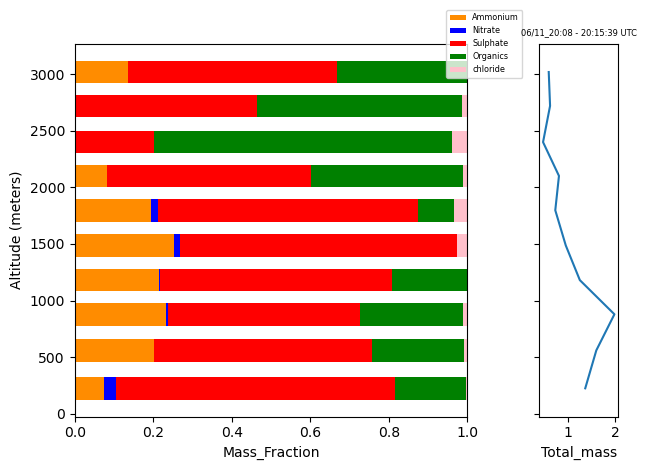

In [320]:
normal11b = (DAY11b_subset_men['Chl_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['Org_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['SO4_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['NO3_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY11b_subset_men['AMS'] = normal11b
DAY11b_subset_men = DAY11b_subset_men.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY11b_subset_men['NH4_Ave_IsoK_STP_ZIEMBA']/normal11b
y2 = DAY11b_subset_men['NO3_Ave_IsoK_STP_ZIEMBA']/normal11b
y3 = DAY11b_subset_men['SO4_Ave_IsoK_STP_ZIEMBA']/normal11b
y4 = DAY11b_subset_men['Org_Ave_IsoK_STP_ZIEMBA']/normal11b
y5 = DAY11b_subset_men['Chl_Ave_IsoK_STP_ZIEMBA']/normal11b
y6 = DAY11b_subset_men['mz44_Ave_IsoK_STP_ZIEMBA']/normal11b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal11b, DAY11b_subset_men['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/11_20:08 - 20:15:39 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [289]:
DAY13 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L1_20230614T111637.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012
...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009


In [290]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,19,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2022-06-13 14:32:44.694736896,2022-06-13 14:32:45.694736896,32.244420,-65.051465,556.049107,0.270172,0.808265,0.025146,0.172765,-0.009805,-0.011944
min,2022-06-13 14:30:32.200000,2022-06-13 14:30:33.200000,32.197392,-65.097735,142.037308,0.070000,0.575000,-0.039923,-0.107000,-0.047000,-0.086000
25%,2022-06-13 14:31:54.500000,2022-06-13 14:31:55.500000,32.212486,-65.083628,359.240333,0.202700,0.701548,-0.009000,0.113750,-0.026000,-0.036182
50%,2022-06-13 14:32:45.500000,2022-06-13 14:32:46.500000,32.245854,-65.051067,556.630833,0.248364,0.849000,0.031083,0.157429,-0.003091,-0.015083
75%,2022-06-13 14:33:39.249999872,2022-06-13 14:33:40.249999872,32.275700,-65.020351,756.111250,0.298000,0.916100,0.053955,0.276462,0.001000,0.011875
max,2022-06-13 14:34:30.500000,2022-06-13 14:34:31.500000,32.287260,-64.994298,954.156429,0.580000,0.955000,0.077000,0.325000,0.035308,0.061000
std,NaN,NaN,0.033910,0.035095,249.917479,0.136871,0.132430,0.038893,0.135137,0.022014,0.040461


In [291]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2022-06-13 14:40:30.081818112,2022-06-13 14:40:31.081818368,32.253689,-65.017370,2230.044937,0.156716,0.373154,0.000758,0.113514,0.013087,-0.031428
min,2022-06-13 14:34:55.500000,2022-06-13 14:34:56.500000,32.197171,-65.094145,1042.884167,-0.054000,0.273000,-0.049000,-0.119000,-0.013000,-0.133000
25%,2022-06-13 14:38:08.249999872,2022-06-13 14:38:09.249999872,32.226733,-65.048756,1636.347917,0.048000,0.303550,-0.021000,0.016000,0.008000,-0.058000
50%,2022-06-13 14:41:17.500000,2022-06-13 14:41:18.500000,32.256386,-65.004790,2228.825000,0.105333,0.338333,-0.008000,0.099929,0.009000,-0.024000
75%,2022-06-13 14:42:58.249999872,2022-06-13 14:42:59.249999872,32.281042,-64.986767,2825.135000,0.253800,0.421567,0.025000,0.211058,0.018000,-0.002500
max,2022-06-13 14:44:01,2022-06-13 14:44:02,32.293834,-64.972350,3419.562000,0.655000,0.601000,0.099000,0.332000,0.056000,0.046000
std,NaN,NaN,0.029446,0.037474,705.259840,0.150657,0.094575,0.028587,0.126319,0.013986,0.036863


In [292]:
nbins = 10
bins13 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins13)
DAY13_subset_mean = DAY13_subset.groupby('Bins').mean()
DAY13_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(138.195, 578.542]",2022-06-13 14:31:25.695906304,2022-06-13 14:31:26.695906304,32.251602,-65.029198,287.809064,0.192310,0.780620,0.007415,0.119485,0.013620,-0.014129
"(578.542, 1018.888]",2022-06-13 14:33:50.500000000,2022-06-13 14:33:51.500000000,32.217537,-65.063852,799.163898,0.315407,0.854034,0.024644,0.248814,-0.024797,-0.009576
"(1018.888, 1459.234]",2022-06-13 14:35:59.000000000,2022-06-13 14:36:00.000000000,32.268210,-65.026384,1245.222302,0.153518,0.537201,0.003324,0.188007,0.002295,-0.007094
"(1459.234, 1899.581]",2022-06-13 14:38:21.500000000,2022-06-13 14:38:22.500000000,32.218896,-65.040238,1673.850342,0.293644,0.413781,0.023521,0.171192,0.012986,-0.003973
"(1899.581, 2339.928]",2022-06-13 14:40:39.000000000,2022-06-13 14:40:40.000000000,32.276015,-65.032278,2097.121008,0.130907,0.342721,-0.004543,0.043953,0.012186,-0.048643
"(2339.928, 2780.274]",2022-06-13 14:42:18.500000000,2022-06-13 14:42:19.500000000,32.226927,-65.023434,2512.975286,0.226114,0.331171,-0.016686,0.030314,0.037143,-0.031629
"(2780.274, 3220.62]",2022-06-13 14:43:17.000000000,2022-06-13 14:43:18.000000000,32.263635,-64.977333,2998.251277,0.052213,0.303511,-0.016213,0.148936,0.008532,-0.069234
"(3220.62, 3660.967]",2022-06-13 14:44:04.000000000,2022-06-13 14:44:05.000000000,32.286216,-65.020226,3446.552553,0.090383,0.281149,0.009447,0.066596,0.005681,-0.013872
"(3660.967, 4101.314]",2022-06-13 14:44:51.500000000,2022-06-13 14:44:52.500000000,32.255467,-65.066155,3880.000000,0.064917,0.308250,0.007625,0.299625,-0.011125,-0.052583


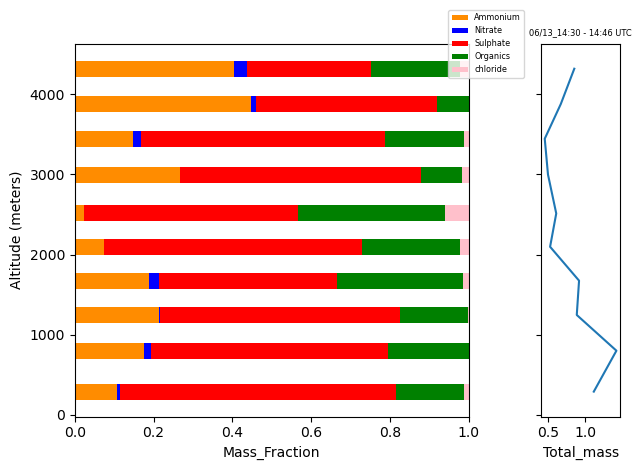

In [293]:
normal13 = (DAY13_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY13_subset_mean['AMS'] = normal13
DAY13_subset_mean = DAY13_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY13_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal13
y2 = DAY13_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal13
y3 = DAY13_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal13
y4 = DAY13_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal13
y5 = DAY13_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal13
y6 = DAY13_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal13
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal13, DAY13_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06/13_14:30 - 14:46 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [294]:
DAY13b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L2_20230614T111637.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036
...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018


In [295]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,19,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2022-06-13 19:48:39.235588864,2022-06-13 19:48:40.235589120,32.251283,-64.963002,531.245099,0.112804,0.485443,-0.017075,0.064697,0.012694,-0.012211
min,2022-06-13 19:46:21.476190464,2022-06-13 19:46:22.476190464,32.223206,-65.001759,121.140833,-0.046800,0.380000,-0.057000,-0.142000,-0.020000,-0.093000
25%,2022-06-13 19:47:40.500000,2022-06-13 19:47:41.500000,32.232798,-64.988673,329.961447,0.012560,0.424000,-0.044000,-0.021000,0.001000,-0.034700
50%,2022-06-13 19:48:37,2022-06-13 19:48:38,32.250778,-64.959460,534.096316,0.122000,0.462000,-0.025000,0.057000,0.021941,-0.007000
75%,2022-06-13 19:49:41.249999872,2022-06-13 19:49:42.249999872,32.270597,-64.938746,733.858157,0.171500,0.565000,-0.001000,0.144000,0.028231,0.017912
max,2022-06-13 19:50:47,2022-06-13 19:50:48,32.284827,-64.927901,932.806818,0.340000,0.695357,0.065881,0.320000,0.033000,0.049000
std,NaN,NaN,0.021802,0.026008,252.706341,0.113510,0.088584,0.034324,0.132975,0.018475,0.042518


In [296]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258703,-64.985245,2234.138114,0.142626,0.363119,0.008990,0.040932,0.006086,-0.028059
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213525,-65.041886,1023.430000,-0.130000,0.204000,-0.061861,-0.170000,-0.043477,-0.121000
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234643,-65.005720,1627.179611,0.083167,0.267000,-0.013370,-0.051545,-0.004889,-0.047000
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262861,-64.985925,2236.028333,0.141000,0.296000,0.013000,0.069538,0.000000,-0.027000
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282607,-64.966122,2838.776270,0.211346,0.400000,0.021000,0.112000,0.018357,-0.011500
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293438,-64.930466,3445.874000,0.442000,0.692000,0.086000,0.259000,0.053000,0.038000
std,NaN,NaN,0.025029,0.027589,718.104350,0.118570,0.136915,0.030818,0.109318,0.017133,0.034882


In [297]:
nbins = 10
bins13b = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins13)
DAY13b_subset_mean = DAY13b_subset.groupby('Bins').mean()
DAY13b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(138.195, 578.542]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000000000,32.258422,-64.952551,363.200851,0.062319,0.511879,-0.007908,0.040957,0.001213,-0.029872
"(578.542, 1018.888]",2022-06-13 19:50:03.000,2022-06-13 19:50:04.000000000,32.245452,-64.968583,800.856822,0.169256,0.456775,-0.031605,0.120589,0.024984,0.010326
"(1018.888, 1459.234]",2022-06-13 19:52:17.500,2022-06-13 19:52:18.500000000,32.265466,-64.999528,1267.317929,0.111829,0.610893,0.020321,0.070293,0.025936,-0.007307
"(1459.234, 1899.581]",2022-06-13 19:56:02.500,2022-06-13 19:56:03.500000000,32.254047,-64.987997,1690.909935,0.125919,0.336723,-0.005832,0.157868,-0.011210,-0.023006
"(1899.581, 2339.928]",2022-06-13 20:00:32.500,2022-06-13 20:00:33.500000000,32.266872,-64.987326,2080.553304,0.164226,0.255252,-0.000487,0.053748,0.004687,-0.026700
"(2339.928, 2780.274]",2022-06-13 20:03:43.000,2022-06-13 20:03:44.000000000,32.245894,-64.967257,2565.530596,0.113457,0.290272,0.032404,-0.092172,0.014457,-0.030199
"(2780.274, 3220.62]",2022-06-13 20:05:33.500,2022-06-13 20:05:34.500000000,32.266075,-64.993830,2990.786857,0.141829,0.287486,0.002957,0.018529,-0.002100,-0.035743
"(3220.62, 3660.967]",2022-06-13 20:06:34.500,2022-06-13 20:06:35.499999744,32.224856,-64.964075,3438.893462,0.335077,0.349385,-0.005500,0.011654,0.002962,-0.006577
"(3660.967, 4101.314]",2022-06-13 20:07:26.000,2022-06-13 20:07:27.000000000,32.259428,-64.919134,3884.520588,0.466471,0.337980,0.002412,0.290392,0.013000,0.031294


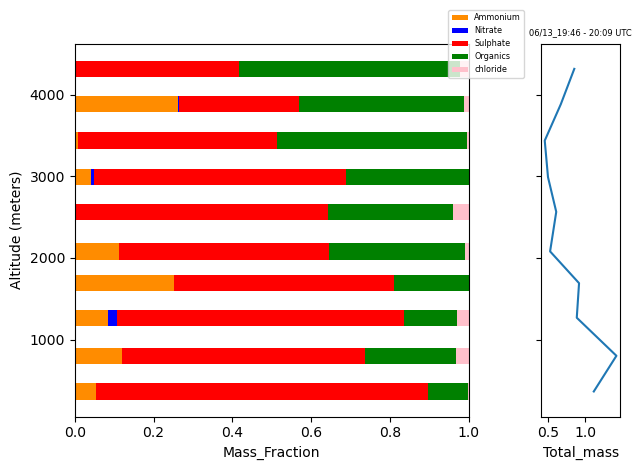

In [298]:
normal13b = (DAY13b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY13b_subset_mean['AMS'] = normal13b
DAY13b_subset_mean = DAY13b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY13b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal13b
y2 = DAY13b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal13b
y3 = DAY13b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal13b
y4 = DAY13b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal13b
y5 = DAY13b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal13b
y6 = DAY13b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal13b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal13, DAY13b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06/13_19:46 - 20:09 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [299]:
DAY14 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220614_R0_20230614T111638.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020
...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089


In [300]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-14 16:06:20.549999872,2022-06-14 16:06:21.549999872,30.665996,-64.421215,532.612161,0.151320,0.778640,0.007758,0.145120,0.018219,-0.024017
min,2022-06-14 16:05:20,2022-06-14 16:05:21,30.635158,-64.443667,129.846923,-0.133000,0.499000,-0.061000,-0.018333,-0.010000,-0.049000
25%,2022-06-14 16:05:57.624999936,2022-06-14 16:05:58.624999936,30.654523,-64.438572,347.133625,0.070583,0.701000,-0.011583,0.095250,-0.001231,-0.047000
50%,2022-06-14 16:06:21.750000128,2022-06-14 16:06:22.750000128,30.670587,-64.423276,535.254470,0.176600,0.805115,0.022100,0.172583,0.015000,-0.035817
75%,2022-06-14 16:06:46,2022-06-14 16:06:47,30.679871,-64.407655,723.516250,0.276667,0.840625,0.024000,0.228525,0.038875,-0.002000
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,30.684512,-64.387230,913.690000,0.428000,0.984000,0.054718,0.235000,0.055000,0.015128
std,NaN,NaN,0.017557,0.020702,258.194532,0.181349,0.150520,0.032035,0.101119,0.024588,0.026894


In [301]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665512,-64.406044,2207.918130,0.266287,0.208536,0.011087,0.009928,0.016691,0.006289
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637684,-64.436561,1077.070000,-0.110000,0.091000,-0.043000,-0.283000,-0.014000,-0.054000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644458,-64.425179,1642.586361,0.190850,0.148600,-0.017275,-0.066000,0.000000,-0.019000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661879,-64.407742,2206.432056,0.274000,0.171000,0.014000,-0.016000,0.016000,0.013000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684682,-64.388273,2773.432083,0.376500,0.252000,0.039000,0.092000,0.031925,0.039000
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699582,-64.368152,3338.431111,0.572000,0.461500,0.078000,0.272000,0.048000,0.050000
std,NaN,NaN,0.021283,0.022013,688.131611,0.193180,0.096754,0.034966,0.150640,0.018297,0.033700


In [302]:
nbins = 10
bins14 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins14)
DAY14_subset_mean = DAY14_subset.groupby('Bins').mean()
DAY14_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(117.0, 953.333]",2022-06-14 16:06:08.000000000,2022-06-14 16:06:09.000000000,30.659707,-64.419702,449.283185,0.173385,0.783956,0.017867,0.111356,0.014259,-0.016044
"(953.333, 1789.666]",2022-06-14 16:08:03.500000000,2022-06-14 16:08:04.500000000,30.654197,-64.414863,1375.408281,0.454771,0.342229,-0.012562,0.002104,0.005917,0.029813
"(1789.666, 2625.999]",2022-06-14 16:09:40.000000000,2022-06-14 16:09:40.999999744,30.671456,-64.386691,2214.643608,0.116773,0.131515,0.004773,-0.092412,0.018113,-0.014134
"(2625.999, 3462.332]",2022-06-14 16:11:19.000000000,2022-06-14 16:11:20.000000000,30.672396,-64.412405,3038.086436,0.237327,0.178644,0.036782,0.108426,0.023941,0.006000
"(3462.332, 4298.665]",2022-06-14 16:13:08.499999744,2022-06-14 16:13:09.500000000,30.659536,-64.388819,3904.438390,0.216246,0.166576,0.018136,-0.029339,0.007678,0.008966
"(4298.665, 5134.998]",2022-06-14 16:15:22.000000000,2022-06-14 16:15:23.000000000,30.671316,-64.376391,4717.452752,0.331483,0.095376,0.010879,-0.137846,-0.012597,0.012221
"(5134.998, 5971.331]",2022-06-14 16:17:35.000000000,2022-06-14 16:17:35.999999744,30.689983,-64.382142,5540.587863,0.086641,0.103658,0.005376,-0.007786,-0.001214,0.007282
"(5971.331, 6807.664]",2022-06-14 16:19:28.500000000,2022-06-14 16:19:29.500000000,30.661610,-64.384839,6378.099091,0.354036,0.106091,-0.013600,0.024255,-0.000991,0.044182
"(6807.664, 7643.997]",2022-06-14 16:21:24.000000000,2022-06-14 16:21:25.000000000,30.681770,-64.355255,7271.420661,0.391860,0.098860,0.002537,0.122545,0.019967,0.016107


In [303]:
DAY14_subset_mean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-14 16:14:35.049999872,2022-06-14 16:14:36.049999872,30.677174,-64.394643,4294.355885,0.279006,0.216078,0.019470,0.028654,0.007352,0.009853
min,2022-06-14 16:06:08,2022-06-14 16:06:09,30.654197,-64.425318,449.283185,0.086641,0.095376,-0.013600,-0.137846,-0.012597,-0.016044
25%,2022-06-14 16:10:04.750000128,2022-06-14 16:10:05.749999872,30.660182,-64.414249,2420.504315,0.184100,0.104266,0.003096,-0.023951,-0.001158,0.004602
50%,2022-06-14 16:14:15.249999872,2022-06-14 16:14:16.249999872,30.671386,-64.387755,4310.945571,0.284405,0.142696,0.008128,0.013179,0.006797,0.008124
75%,2022-06-14 16:19:00.124999936,2022-06-14 16:19:01.124999936,30.679426,-64.382816,6168.721284,0.382404,0.175627,0.018068,0.110623,0.017150,0.015136
max,2022-06-14 16:23:42,2022-06-14 16:23:43,30.749767,-64.355255,8054.138581,0.454771,0.783956,0.124516,0.185239,0.023941,0.044182
std,NaN,NaN,0.027751,0.022428,2548.055083,0.130908,0.212476,0.039768,0.102378,0.011644,0.018020


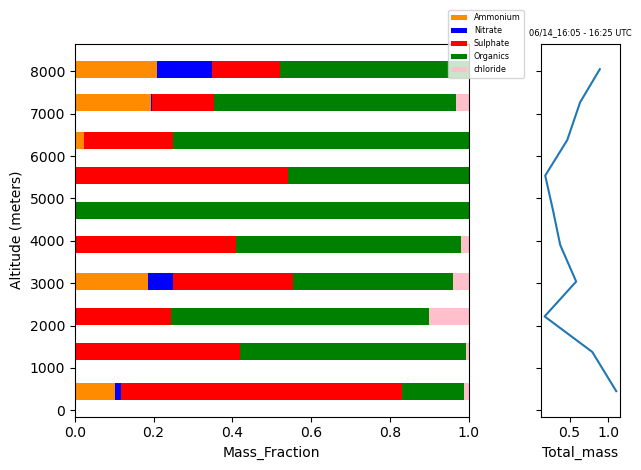

In [304]:
normal14 = (DAY14_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY14_subset_mean['AMS'] = normal14
DAY14_subset_mean = DAY14_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY14_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal14
y2 = DAY14_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal14
y3 = DAY14_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal14
y4 = DAY14_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal14
y5 = DAY14_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal14
y6 = DAY14_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal14
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY14_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal14, DAY14_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06/14_16:05 - 16:25 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [305]:
DAY17 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220617_R0_20230614T111638.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016
...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004


In [306]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,11,11,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2022-06-17 16:22:51.845070592,2022-06-17 16:22:52.845070336,32.237853,-64.999281,537.166776,0.701616,0.739437,0.015330,0.269795,-0.000103,0.046027
min,2022-06-17 16:20:35.295774720,2022-06-17 16:20:36.295774720,32.213844,-65.043782,138.339507,0.242000,0.589000,-0.058000,-0.039000,-0.041304,-0.013000
25%,2022-06-17 16:22:01.500000,2022-06-17 16:22:02.500000,32.222402,-65.012799,351.893329,0.517331,0.642260,-0.009750,0.081214,-0.027500,0.022930
50%,2022-06-17 16:22:57,2022-06-17 16:22:58,32.239178,-64.995274,541.829286,0.616714,0.677043,0.031169,0.308380,-0.005870,0.043000
75%,2022-06-17 16:23:48.500000,2022-06-17 16:23:49.500000,32.252117,-64.979576,725.054302,0.875704,0.838130,0.047000,0.425826,0.021112,0.072472
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.263103,-64.968086,919.207250,1.201947,0.963300,0.064000,0.594000,0.053500,0.095000
std,NaN,NaN,0.016975,0.024119,253.912383,0.294046,0.129922,0.042301,0.210683,0.033592,0.034606


In [307]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,32,32,32.000000,32.000000,32.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2022-06-17 16:34:08.953124864,2022-06-17 16:34:09.953125120,32.214209,-65.013055,2235.716062,0.594771,0.532336,0.039145,0.225593,0.017460,0.038358
min,2022-06-17 16:25:25,2022-06-17 16:25:26,32.178844,-65.051537,1069.572000,0.187310,0.127000,-0.026000,0.002000,-0.032931,-0.049000
25%,2022-06-17 16:32:07.249999872,2022-06-17 16:32:08.250000128,32.191975,-65.038791,1649.697685,0.485550,0.185091,-0.009216,0.153912,-0.002222,0.025909
50%,2022-06-17 16:35:19.249999872,2022-06-17 16:35:20.249999872,32.210141,-65.014286,2234.973551,0.564875,0.268000,0.030156,0.241000,0.022333,0.038200
75%,2022-06-17 16:36:48,2022-06-17 16:36:49,32.238503,-64.988837,2819.493000,0.659596,0.631000,0.088333,0.302583,0.030477,0.050750
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.252481,-64.972554,3406.321000,1.058000,1.875333,0.118000,0.471000,0.065000,0.106000
std,NaN,NaN,0.024051,0.026619,707.975643,0.167592,0.549962,0.049621,0.129971,0.028583,0.034097


In [308]:
nbins = 10
bins17 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins17)
DAY17_subset_mean = DAY17_subset.groupby('Bins').mean()
DAY17_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(124.73, 878.885]",2022-06-17 16:22:15.815497984,2022-06-17 16:22:16.815497984,32.234894,-64.992273,425.629668,0.649572,0.689498,0.017332,0.250210,0.001661,0.044786
"(878.885, 1633.04]",2022-06-17 16:28:16.000000000,2022-06-17 16:28:17.000000000,32.220790,-65.014841,1245.529454,0.672147,1.121767,0.010377,0.223233,0.012800,0.040140
"(1633.04, 2387.195]",2022-06-17 16:33:52.000000000,2022-06-17 16:33:53.000000000,32.219952,-65.007689,1960.842466,0.568192,0.591845,0.033083,0.271751,-0.011062,0.048425
"(2387.195, 3141.35]",2022-06-17 16:36:38.500000000,2022-06-17 16:36:39.499999744,32.218805,-65.029606,2756.544455,0.536636,0.192091,0.077773,0.195091,0.028591,0.033318
"(3141.35, 3895.505]",2022-06-17 16:38:20.000000000,2022-06-17 16:38:21.000000000,32.210228,-64.984610,3508.160430,0.788774,0.201118,0.038989,0.114570,0.044118,0.063495
"(3895.505, 4649.66]",2022-06-17 16:39:50.500000000,2022-06-17 16:39:51.500000000,32.200044,-65.029024,4280.062045,0.515386,0.129455,0.092045,0.209364,0.024068,0.028114
"(4649.66, 5403.815]",2022-06-17 16:41:15.500000000,2022-06-17 16:41:16.500000000,32.185069,-64.959899,5029.384512,0.165610,0.207805,0.088293,0.145659,0.006390,-0.012122
"(5403.815, 6157.97]",2022-06-17 16:42:40.000000000,2022-06-17 16:42:41.000000000,32.223073,-65.009439,5785.719310,1.301816,0.205954,0.147563,0.030736,-0.014207,0.202103
"(6157.97, 6912.125]",2022-06-17 16:44:13.499999744,2022-06-17 16:44:14.500000000,32.163536,-64.979062,6545.490900,2.123500,0.081150,0.153150,0.401150,0.021650,0.348700


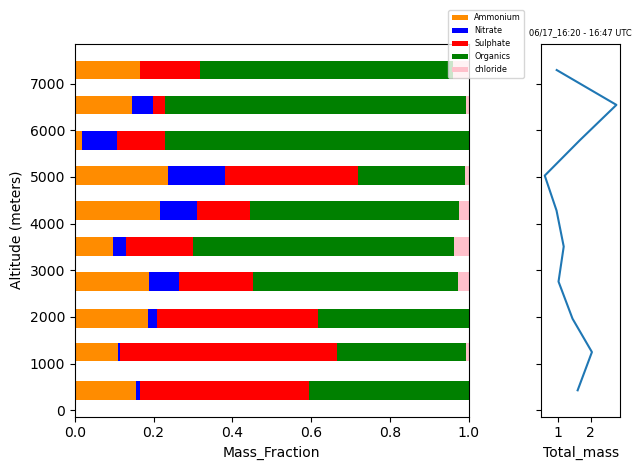

In [309]:
normal17 = (DAY17_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY17_subset_mean['AMS'] = normal17
DAY17_subset_mean = DAY17_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY17_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal17
y2 = DAY17_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal17
y3 = DAY17_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal17
y4 = DAY17_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal17
y5 = DAY17_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal17
y6 = DAY17_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal17
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY17_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal17, DAY17_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06/17_16:20 - 16:47 UTC', fontsize=6)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [310]:
DAY18 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220618_R0_20230614T111638.ict')
start_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:09:00"))
stop_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:33:00"))    
DAY18_subset = DAY18[start_index[0][0]:stop_index[0][0]]
#DAY18_subset = DAY18_subset.replace(-888888, 0)
DAY18_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7425,2022-06-18 14:09:00,2022-06-18 14:09:01,36.589500,-71.990803,110.135,4.910,1.114,0.234,0.181,0.013,0.556
7426,2022-06-18 14:09:01,2022-06-18 14:09:02,36.590250,-71.991516,110.155,4.910,1.114,0.234,0.181,0.013,0.556
7427,2022-06-18 14:09:02,2022-06-18 14:09:03,36.591026,-71.992186,109.965,4.910,1.114,0.234,0.181,0.013,0.556
7428,2022-06-18 14:09:03,2022-06-18 14:09:04,36.591824,-71.992808,109.535,4.910,1.114,0.234,0.181,0.013,0.556
7429,2022-06-18 14:09:04,2022-06-18 14:09:05,36.592643,-71.993383,109.055,4.910,1.114,0.234,0.181,0.013,0.556
...,...,...,...,...,...,...,...,...,...,...,...
8860,2022-06-18 14:32:55,2022-06-18 14:32:56,36.634224,-71.921855,7949.270,0.554,0.095,0.145,0.197,0.001,-0.019
8861,2022-06-18 14:32:56,2022-06-18 14:32:57,36.634412,-71.923239,7954.260,0.554,0.095,0.145,0.197,0.001,-0.019
8862,2022-06-18 14:32:57,2022-06-18 14:32:58,36.634602,-71.924625,7959.290,0.554,0.095,0.145,0.197,0.001,-0.019
8863,2022-06-18 14:32:58,2022-06-18 14:32:59,36.634793,-71.926012,7964.380,0.554,0.095,0.145,0.197,0.001,-0.019


In [311]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY18_subset.GPS_Altitude_THORNHILL.min(), DAY18_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY18_subset['Bins'] = pd.cut(DAY18_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY18_subset_1000 = DAY18_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_18 = DAY18_subset_1000[start_index:stop_index]
DAY1000_subset_18.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-18 14:11:38.374137856,2022-06-18 14:11:39.374138112,36.608924,-72.004370,496.944384,5.453914,1.146725,0.233951,0.593170,0.004602,0.620773
min,2022-06-18 14:09:29.241379328,2022-06-18 14:09:30.241379328,36.566434,-72.047167,132.794655,4.788000,0.806000,0.148000,0.431957,-0.026143,0.521000
25%,2022-06-18 14:10:46.875000064,2022-06-18 14:10:47.875000064,36.586033,-72.034436,321.789448,5.265724,1.095345,0.214123,0.486012,-0.023304,0.568636
50%,2022-06-18 14:11:39.500000,2022-06-18 14:11:40.500000,36.608750,-72.005418,495.300240,5.508727,1.150478,0.236384,0.550197,0.006072,0.628695
75%,2022-06-18 14:12:33.500000,2022-06-18 14:12:34.500000,36.631835,-71.983900,680.431436,5.691983,1.213841,0.259593,0.606675,0.027150,0.675043
max,2022-06-18 14:13:32.999999744,2022-06-18 14:13:34.000000256,36.654091,-71.955549,852.631522,5.870609,1.360789,0.343000,1.067000,0.040667,0.698000
std,NaN,NaN,0.031193,0.033269,241.050369,0.360047,0.155313,0.055220,0.189373,0.028164,0.062988


In [312]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY18_subset_3000 = DAY18_subset_1000[start_index:stop_index]
DAY18_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,31,31,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,2022-06-18 14:19:04.016129024,2022-06-18 14:19:05.016129024,36.583673,-71.978208,2189.291455,3.512008,0.815906,0.216833,0.378666,0.018265,0.412719
min,2022-06-18 14:14:13,2022-06-18 14:14:14,36.537275,-72.042481,1011.794412,0.945000,0.342000,0.058000,-0.118000,-0.016000,0.104000
25%,2022-06-18 14:16:57.750000128,2022-06-18 14:16:58.750000128,36.557218,-72.002256,1597.906511,1.522600,0.503000,0.085854,0.260966,0.009700,0.208611
50%,2022-06-18 14:19:49.500000,2022-06-18 14:19:50.500000,36.585047,-71.976110,2182.954000,2.417187,0.861471,0.146400,0.375652,0.018000,0.312000
75%,2022-06-18 14:21:12.249999872,2022-06-18 14:21:13.249999872,36.607052,-71.947094,2780.572278,5.550229,1.141473,0.341208,0.431500,0.030635,0.618937
max,2022-06-18 14:22:29,2022-06-18 14:22:30,36.620810,-71.926589,3371.061818,8.099000,1.221273,0.585000,0.890000,0.048000,0.893435
std,NaN,NaN,0.026860,0.035843,715.257157,2.314682,0.313673,0.157308,0.234088,0.017552,0.249953


In [313]:
nbins = 10
bins18 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY18_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY18_subset['Bins'] = pd.cut(DAY18_subset['GPS_Altitude_THORNHILL'], bins18)
DAY18_subset_mean = DAY18_subset.groupby('Bins').mean()
DAY18_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(124.73, 909.207]",2022-06-18 14:11:41.000000000,2022-06-18 14:11:42.000000000,36.610183,-72.001091,503.228996,5.452282,1.138263,0.238320,0.603046,0.003015,0.618402
"(909.207, 1693.684]",2022-06-18 14:15:36.000000000,2022-06-18 14:15:36.999999744,36.581877,-71.988693,1300.652796,4.755891,1.101204,0.260512,0.478578,0.021114,0.545578
"(1693.684, 2478.161]",2022-06-18 14:18:57.500000000,2022-06-18 14:18:58.500000000,36.580154,-72.005298,2032.031406,5.178927,0.964771,0.327687,0.463531,0.015948,0.592240
"(2478.161, 3262.638]",2022-06-18 14:21:24.000000000,2022-06-18 14:21:24.999999744,36.596463,-71.950082,2868.392475,1.450465,0.520000,0.099614,0.210634,0.015931,0.191713
"(3262.638, 4047.115]",2022-06-18 14:23:05.000000256,2022-06-18 14:23:06.000000000,36.558148,-71.955376,3649.032772,1.327634,0.397842,0.164822,0.234119,0.009327,0.154990
"(4047.115, 4831.592]",2022-06-18 14:24:47.000000000,2022-06-18 14:24:48.000000000,36.595963,-71.928190,4444.606796,0.510767,0.200883,0.018214,-0.006767,0.026320,0.035359
"(4831.592, 5616.069]",2022-06-18 14:26:27.500000000,2022-06-18 14:26:28.499999744,36.544014,-71.967369,5222.732653,0.429633,0.064224,0.010980,-0.010673,0.011122,0.030490
"(5616.069, 6400.546]",2022-06-18 14:28:04.500000000,2022-06-18 14:28:05.500000000,36.573659,-71.910634,6016.558646,0.369656,0.085031,-0.000562,-0.077250,-0.009531,-0.021583
"(6400.546, 7185.023]",2022-06-18 14:29:46.000000000,2022-06-18 14:29:47.000000000,36.537477,-71.910698,6808.280935,0.145645,0.113897,-0.023607,0.276121,0.013523,0.004570


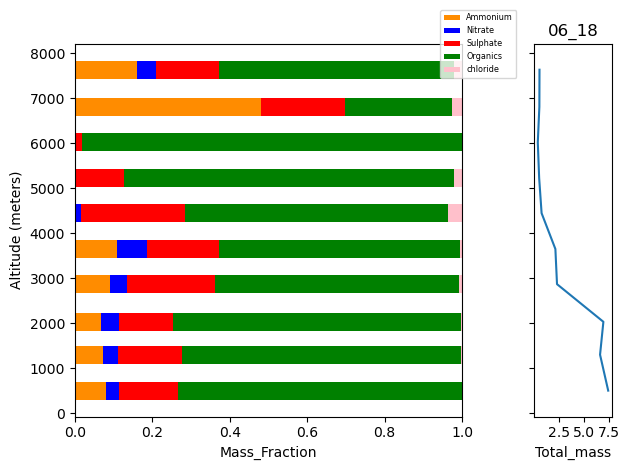

In [314]:
normal18 = (DAY18_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY18_subset_mean['AMS'] = normal8
DAY18_subset_mean = DAY18_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY18_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal18
y2 = DAY18_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal18
y3 = DAY18_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal18
y4 = DAY18_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal18
y5 = DAY18_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal18
y6 = DAY18_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal18
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY18_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal18, DAY18_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_18')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [315]:

'''# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([DAY1000_subset_1000.describe(), DAY3000_subset_3000.describe(), DAY1000_subset_1000b.describe(), DAY3000_subset_3000b.describe(), DAY1000_subset_3.describe(), DAY3_subset_3000.describe(), DAY1000_subset_7.describe(), DAY7_subset_3000.describe(), DAY1000_subset_7b.describe(), DAY7b_subset_3000.describe(), DAY1000_subset_8.describe(), DAY8_subset_3000.describe(), DAY1000_subset_10.describe(), DAY10_subset_3000.describe(), DAY1000_subset_10b.describe(), DAY10b_subset_3000.describe(), DAY1000_subset_11.describe(), DAY11_subset_3000.describe(), DAY1000_subset_11b.describe(), DAY11b_subset_3000.describe(), DAY1000_subset_13.describe(), DAY13_subset_3000.describe(), DAY1000_subset_13b.describe(), DAY13b_subset_3000.describe(), DAY1000_subset_14.describe(), DAY14_subset_3000.describe(), DAY1000_subset_17.describe(), DAY17_subset_3000.describe(), DAY1000_subset_18.describe(), DAY18_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chem_description.csv')'''

"# Concatenate the dataframes vertically (along rows)\nmerged_df = pd.concat([DAY1000_subset_1000.describe(), DAY3000_subset_3000.describe(), DAY1000_subset_1000b.describe(), DAY3000_subset_3000b.describe(), DAY1000_subset_3.describe(), DAY3_subset_3000.describe(), DAY1000_subset_7.describe(), DAY7_subset_3000.describe(), DAY1000_subset_7b.describe(), DAY7b_subset_3000.describe(), DAY1000_subset_8.describe(), DAY8_subset_3000.describe(), DAY1000_subset_10.describe(), DAY10_subset_3000.describe(), DAY1000_subset_10b.describe(), DAY10b_subset_3000.describe(), DAY1000_subset_11.describe(), DAY11_subset_3000.describe(), DAY1000_subset_11b.describe(), DAY11b_subset_3000.describe(), DAY1000_subset_13.describe(), DAY13_subset_3000.describe(), DAY1000_subset_13b.describe(), DAY13b_subset_3000.describe(), DAY1000_subset_14.describe(), DAY14_subset_3000.describe(), DAY1000_subset_17.describe(), DAY17_subset_3000.describe(), DAY1000_subset_18.describe(), DAY18_subset_3000.describe()], axis=0)\n\n